# ----------------------------TER Picopatt — Analyse des données -----------------

##  1) Importation des librairies et configuration des chemins

 Importation des librairies principales et définition des dossiers de travail.

In [36]:
from pathlib import Path
import re, unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dossiers de données et de sortie
DATA_DIR = Path("/Users/akkouh/Desktop/dataproc")
OUTPUT_DIR = Path("./outputs"); OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = OUTPUT_DIR / "figures"; FIG_DIR.mkdir(parents=True, exist_ok=True)

# Affichage complet des colonnes
pd.set_option("display.max_columns", 200)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## 2) Fonctions utilitaires

Définition de fonctions pour normaliser les textes, extraire le nom du parcours, parser les dates et attribuer un créneau horaire ('M1'
'M4').

In [37]:
def strip_accents(s):
    # Supprime les accents d'une chaîne
    if pd.isna(s): return s
    return ''.join(c for c in unicodedata.normalize('NFKD', str(s)) if not unicodedata.combining(c))

def normalize_track(x):
    # Nettoie et rassemble les noms de parcours
    if pd.isna(x): return np.nan
    x = strip_accents(str(x)).lower().strip()
    x = x.replace("boulevard", "boulevards")
    if "antigone" in x: return "antigone"
    if "boulevards" in x: return "boulevards"
    if "ecusson" in x: return "ecusson"
    return np.nan

def infer_track_from_filename(name: str):
    # Déduit le parcours à partir du nom du fichier
    n = strip_accents(name.lower())
    if "antigone" in n:   return "antigone"
    if "boulevard" in n:  return "boulevards"
    if "ecusson" in n:    return "ecusson"
    return np.nan

def parse_fr_ts(s):
    # Convertit les dates au format français en datetime
    return pd.to_datetime(s, errors="coerce", dayfirst=True)

def assign_M_slot(ts: pd.Timestamp):
    # Associe chaque timestamp à un créneau horaire (matin, midi, etc.)
    if pd.isna(ts): return np.nan
    h = int(ts.hour)
    if h in (8,9):   return "M1"
    if h in (11,12): return "M2"
    if h in (14,15): return "M3"
    if h in (17,18): return "M4"
    return np.nan

## 3) Chargement et préparation des données

Lecture de tous les fichiers de données ('.csv', '.xlsx') dans le dossier 'DATAproc', nettoyage et harmonisation des colonnes, puis ajout des colonnes 'M_slot' (créneau horaire) et 'date'.

Nous préparons et vérifions les données brutes avant toute analyse.

Comme elles viennent de plusieurs fichiers, plusieurs jours, parcours, on va  :

les fusionner proprement dans un seul tableau,
uniformiser les colonnes (mêmes noms, même format),
et vérifier la couverture temporelle et la répartition des mesures.

In [38]:
from pathlib import Path
import pandas as pd
import numpy as np

def read_any(p: Path) -> pd.DataFrame:
    """Lit un fichier (CSV ou Excel), en essayant plusieurs séparateurs."""
    if p.suffix.lower() in (".xlsx", ".xls"):
        df = pd.read_excel(p)
    else:
        df = None
        for sep in [",", ";", "\t"]:
            try:
                temp = pd.read_csv(p, sep=sep)
                if temp.shape[1] >= 5:  # On considère un fichier valide s'il a plusieurs colonnes
                    df = temp
                    break
            except Exception:
                continue
        if df is None:
            raise ValueError(f"Impossible de lire le fichier : {p}")
    df["__source_file"] = p.name
    return df


def load_all(data_dir: Path) -> pd.DataFrame:
    """Charge et fusionne tous les fichiers du dossier en un seul DataFrame."""
    paths = sorted([p for p in data_dir.rglob("*") if p.suffix.lower() in (".csv", ".xlsx", ".xls")])
    assert paths, f"Aucun fichier trouvé dans {data_dir.resolve()}"

    frames = []
    for p in paths:
        df = read_any(p)

        # Conversion du timestamp
        if "timestamp" in df.columns:
            df["timestamp"] = parse_fr_ts(df["timestamp"])

        # Normalisation du nom de parcours à partir du nom du fichier
        trk_file = infer_track_from_filename(p.name)
        if "track_id" not in df.columns:
            df["track_id"] = trk_file
        else:
            df["track_id"] = df["track_id"].map(normalize_track)
            if df["track_id"].notna().any():
                df["track_id"] = df["track_id"].ffill().bfill()
            df["track_id"] = df["track_id"].fillna(trk_file)

        # Fusion des coordonnées GPS RTK et ontrack
        for c in ["lon_rtk", "lat_rtk", "lon_ontrack", "lat_ontrack"]:
            if c not in df.columns:
                df[c] = np.nan
        df["lon"] = df["lon_rtk"].where(df["lon_rtk"].notna(), df["lon_ontrack"])
        df["lat"] = df["lat_rtk"].where(df["lat_rtk"].notna(), df["lat_ontrack"])

        frames.append(df)

    return pd.concat(frames, ignore_index=True, sort=False)


# --- Chargement complet ---
raw = load_all(DATA_DIR)
raw["M_slot"] = raw["timestamp"].map(assign_M_slot)
raw["date"] = raw["timestamp"].dt.date

# --- Résumé rapide ---
print("Couverture :", raw["timestamp"].min(), "->", raw["timestamp"].max())
print("Parcours :", raw["track_id"].dropna().unique())
print(
    raw.pivot_table(index="track_id", columns="M_slot",
                    values="timestamp", aggfunc="count")
       .fillna(0)
       .astype(int)
)

/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_84006/2164694065.py:26: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)
/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_84006/2164694065.py:26: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)
/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_84006/2164694065.py:26: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  return pd.to_datetime(s, errors="coerce", dayfirst=True)
/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_84006/2164694065.py:26: UserWarning: Parsing da

Couverture : 2024-03-12 08:30:07 -> 2025-09-01 19:08:20
Parcours : ['antigone' 'boulevards' 'ecusson']
M_slot         M1     M2     M3     M4
track_id                              
antigone    27523  27190  29139  28923
boulevards  21279  28399  18017  24694
ecusson     19761  20945  17813  15822


## Résultat:

Les données couvrent un intervalle de temps.
On distingue trois zones de collecte principales du chariot : antigone, boulevards et ecusson.

On observe également quatre passages par jour (matin, midi, après-midi et soir), réalisés à différents moments de la journée.

Globalement, la base de données est bonne et bien équilibrée entre les parcours et les passages.
Cependant, on remarque que le parcours Écusson contient un peu moins de données, ce qui peut indiquer que certains passages n’ont pas été effectués, qu’un problème de mesure est survenu ou tout simplement moins de mesures ont été éffectues pour ecusson.

## 4) Analyse exploratoire rapide

### 4.1) Comptage global par parcours



Affiche la période couverte par les données, la liste des parcours disponibles, le taux de valeurs manquantes globales et des variables météo, et le nombre d’enregistrements par parcours et par créneau horaire ('M_slot').


Couverture temporelle : 2024-03-12 08:30:07 -> 2025-09-01 19:08:20
Parcours disponibles : ['antigone' 'boulevards' 'ecusson']
Taux de valeurs manquantes (top 20) :


project_id          0.999786
section_warning     0.999660
section_speed       0.988983
section_weather     0.988983
section_duration    0.988983
M_slot              0.181012
passage_slot        0.181012
gnss_accuracy       0.000006
lon_rtk             0.000006
lat_rtk             0.000006
point_id            0.000000
lw_right            0.000000
sw_right            0.000000
lw_up               0.000000
lw_down             0.000000
lw_front            0.000000
lw_back             0.000000
lw_left             0.000000
tmrt                0.000000
sw_back             0.000000
dtype: float64

Comptage par parcours :


track_id
antigone      121457
boulevards    115962
ecusson       103862
Name: count, dtype: int64

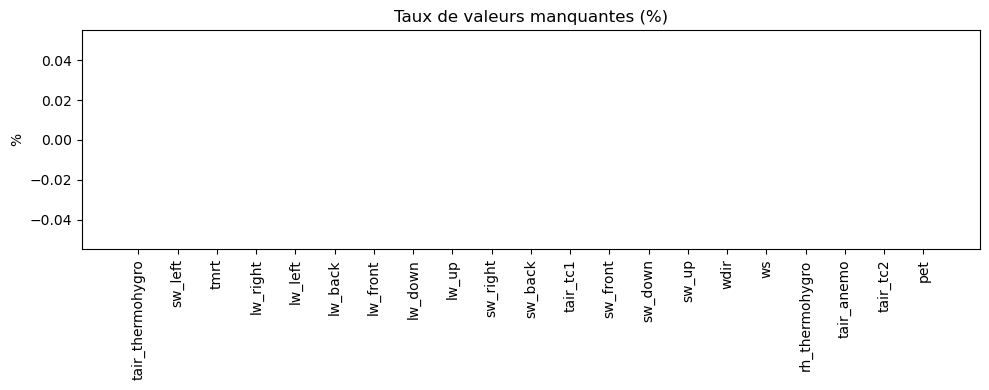

In [32]:
# Période temporelle couverte 
print("Couverture temporelle :", raw["timestamp"].min(), "->", raw["timestamp"].max())

# Liste des parcours présents dans les données
print("Parcours disponibles :", raw["track_id"].dropna().unique())

# Taux de valeurs manquantes (20 colonnes les plus concernées)
missing = raw.isna().mean().sort_values(ascending=False)
print("Taux de valeurs manquantes (top 20) :")
display(missing.head(20))

# Comptage global par parcours
print("Comptage par parcours :")
display(raw["track_id"].value_counts())

# Calcul du pourcentage de valeurs manquantes sur les variables météo
na = raw[METEO].isna().mean().sort_values(ascending=False) * 100

# Visualisation graphique
plt.figure(figsize=(10, 4))
plt.bar(na.index, na.values)
plt.title("Taux de valeurs manquantes (%)")
plt.xticks(rotation=90)
plt.ylabel("%")
plt.tight_layout()
plt.savefig(FIG_DIR / "na_pct_vars.png", dpi=150)
plt.show()

## Résultat:

Les variables de mesures principales présentent très peu de valeurs manquantes, ce qui garantit une base de données fiable et exploitable.

Certaines colonnes pour les sections sont quasiment vides, ce qui est normal compte tenu de la configuration du jeu de données, et elles pourront donc être ignorées lors des analyses.

On observe également le nombre total de relevés par parcours, avec Écusson qui présente le volume le plus faible.


### 4.2) Comptage croisé : parcours x créneau horaire

 Carte de chaleur des échantillons par parcours et créneau horaire

Ce bloc affiche une **heatmap** montrant le **nombre d’échantillons collectés** pour chaque combinaison `parcours × M_slot` (M1 à M4).  
Cela permet d’identifier les périodes ou parcours avec plus ou moins de données.

Nombre d’échantillons par parcours et par créneau horaire :


M_slot,M1,M2,M3,M4
track_id,,,,
antigone,27523,27190,29139,28923
boulevards,21279,28399,18017,24694
ecusson,19761,20945,17813,15822


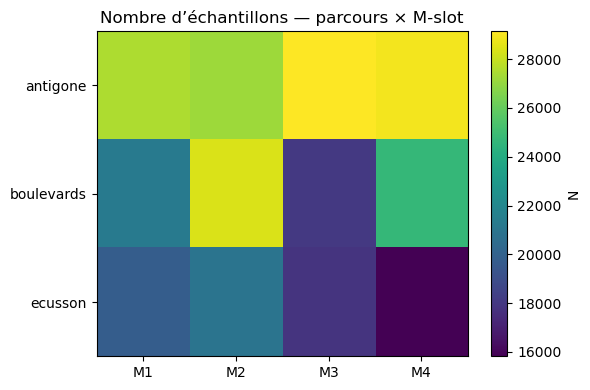

In [35]:
# ## Répartition des mesures par parcours et créneau horaire (M-slot)

# Comptage croisé : parcours × créneau horaire
raw["passage_slot"] = raw["M_slot"]

# Tableau récapitulatif du nombre de mesures
tab = (
    raw.dropna(subset=["track_id", "M_slot"])
       .pivot_table(
           index="track_id",
           columns="M_slot",
           values="timestamp",
           aggfunc="count",
           observed=True
       )
       .reindex(columns=["M1", "M2", "M3", "M4"])
       .fillna(0)
       .astype(int)
)

# Affichage du tableau
print("Nombre d’échantillons par parcours et par créneau horaire :")
display(tab)

# --- Visualisation : Heatmap ---
plt.figure(figsize=(6, 4))
plt.imshow(tab.values, aspect="auto")
plt.xticks(range(tab.shape[1]), tab.columns)
plt.yticks(range(tab.shape[0]), tab.index)
plt.title("Nombre d’échantillons — parcours × M-slot")
plt.colorbar(label="N")
plt.tight_layout()

# Sauvegarde et affichage
plt.savefig(FIG_DIR / "heatmap_counts_parcours_M.png", dpi=150)
plt.show()

# Résultat:


	•	Le parcours Antigone possède le plus grand nombre de mesures sur l’ensemble des créneaux.
	•	Le parcours Boulevards présente davantage de données sur le créneau M2 (midi), mais moins sur M3 (après-midi).
	•	Le parcours Écusson contient globalement moins de mesures sur tous les créneaux.
	•	Le jeu de données couvre bien les quatre créneaux horaires de la journée (M1, M2, M3, M4) pour chaque parcours.

#  5) Pourquoi Écusson a moins de données ?

/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_84006/1596450607.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.drop_duplicates(subset=["date", "M_slot"]).shape[0])


,track_id,date_debut,date_fin,nb_jours,nb_passages,M1,M2,M3,M4
0,antigone,2024-06-12 14:44:05,2025-09-01 19:08:20,8,29,7,7,8,7
1,boulevards,2024-05-12 08:30:27,2025-07-01 19:10:08,7,23,5,7,5,6
2,ecusson,2024-03-12 08:30:07,2025-01-14 19:18:28,7,21,6,6,5,4


<Figure size 800x500 with 0 Axes>

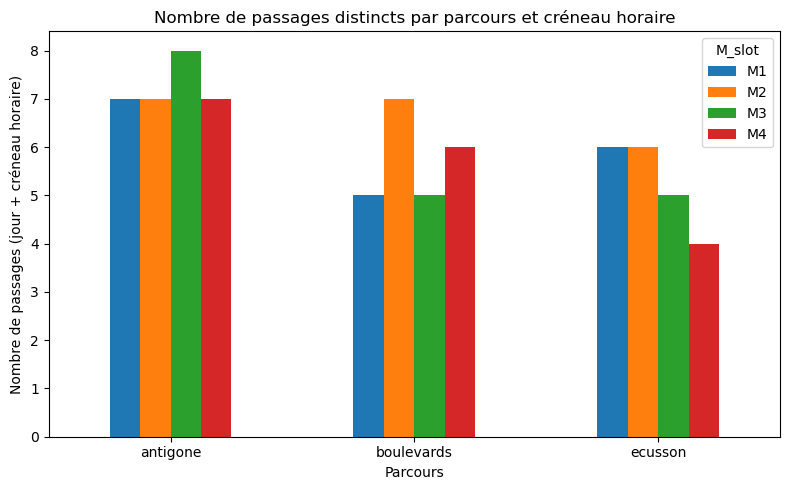

In [51]:
# Période de mesure et nombre de jours distincts
periode_parcours = (
    raw.dropna(subset=["track_id", "timestamp"])
       .groupby("track_id")
       .agg(
           date_debut=("timestamp", "min"),
           date_fin=("timestamp", "max"),
           nb_jours=("date", "nunique")
       )
       .reset_index()
)

# Nombre total de passages (jour + M_slot) par parcours
nb_passages_par_parcours = (
    raw.dropna(subset=["track_id", "M_slot", "date"])
       .groupby("track_id")[["date", "M_slot"]]
       .apply(lambda x: x.drop_duplicates(subset=["date", "M_slot"]).shape[0])
       .reset_index(name="nb_passages")
)

# Détail des passages par créneau horaire (M1, M2, M3, M4)
nb_passages_par_Mslot = (
    raw.dropna(subset=["track_id", "M_slot", "date"])
       .groupby(["track_id", "M_slot"])
       .apply(lambda x: x.drop_duplicates(subset=["date", "M_slot"]).shape[0])
       .reset_index(name="nb_passages")
       .pivot(index="track_id", columns="M_slot", values="nb_passages")
       .fillna(0)
       .astype(int)
)

# Fusion des résultats en un tableau unique
synthese_passages = (
    periode_parcours
    .merge(nb_passages_par_parcours, on="track_id", how="left")
    .merge(nb_passages_par_Mslot, on="track_id", how="left")
)

display(synthese_passages)

## Nombre de passages par parcours et créneau horaire

plt.figure(figsize=(8, 5))
nb_passages_par_Mslot.plot(
    kind="bar",
    figsize=(8, 5),
    rot=0,
    title="Nombre de passages distincts par parcours et créneau horaire"
)
plt.xlabel("Parcours")
plt.ylabel("Nombre de passages (jour + créneau horaire)")
plt.tight_layout()

# Sauvegarde et affichage
plt.savefig(FIG_DIR / "nb_passages_distincts_par_Mslot.png", dpi=150)
plt.show()

In [52]:
from pathlib import Path
import pandas as pd

# Dossier contenant les fichiers
DATA_DIR = Path("/Users/akkouh/Desktop/dataproc")

# récupère uniquement les fichiers liés à "ecusson"
paths_ecusson = sorted([p for p in DATA_DIR.rglob("*ecusson*") if p.suffix.lower() in (".csv", ".xlsx", ".xls")])

#  lire un fichier et extraire les dates présentes
def get_dates_from_file(p):
    try:
        if p.suffix.lower() in (".xlsx", ".xls"):
            df = pd.read_excel(p)
        else:
            df = pd.read_csv(p, sep=None, engine="python")  # détection auto du séparateur
        if "timestamp" in df.columns:
            df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
            return sorted(df["timestamp"].dropna().dt.date.unique())
        else:
            return []
    except Exception as e:
        print(f" Erreur lecture {p.name}: {e}")
        return []

#  tableau récapitulatif
file_dates = pd.DataFrame([
    {"fichier": p.name, "dates_trouvées": get_dates_from_file(p)}
    for p in paths_ecusson
])

# Affichage du résultat
display(file_dates)

#  combien de jours distincts au total :
all_dates = sorted({d for sublist in file_dates["dates_trouvées"] for d in sublist})
print(f"\n Nombre total de jours uniques mesurés pour ECUSSON : {len(all_dates)}")

/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_84006/1626890635.py:18: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_84006/1626890635.py:18: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_84006/1626890635.py:18: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", dayfirst=True)
/var/folders/xz/8qmtfxds1qdftct

,fichier,dates_trouvées
0,picopatt_montpellier_ecusson_20241031_0827.csv,[2024-10-31]
1,picopatt_montpellier_ecusson_20241031_1127.csv,[2024-10-31]
2,picopatt_montpellier_ecusson_20241031_1425.csv,[2024-10-31]
3,picopatt_montpellier_ecusson_20241112_0830.csv,[2024-12-11]
4,picopatt_montpellier_ecusson_20241112_1124.csv,[2024-12-11]
5,picopatt_montpellier_ecusson_20241112_1430.csv,[2024-12-11]
6,picopatt_montpellier_ecusson_20241112_1723.csv,[2024-12-11]
7,picopatt_montpellier_ecusson_20241121_0832.csv,[2024-11-21]
8,picopatt_montpellier_ecusson_20241121_1729.csv,[2024-11-21]
9,picopatt_montpellier_ecusson_20241203_0829.csv,[2024-03-12]



 Nombre total de jours uniques mesurés pour ECUSSON : 7


## Resultat

Ces résultats montrent que les mesures ont été réalisées sur une période, mais seulement sur quelques journées d’acquisition par parcours.
Le parcours Antigone a bénéficié de la couverture la plus complète, tandis que Écusson présente le moins de passages.

Elle contient un jour en moins que antigone comme boulevards mais plsu explicite sur les passages ou elle detinet le moins de passages sur le parcours.

Cela montre pourquoi ecusson regroupe moins de valeur



# 5.1) Vérification des sections mesurées pour le parcours Écusson

In [21]:
# On isole le parcours "antigone"
df_ecusson = raw[raw["track_id"] == "ecusson"]

# Liste des sections présentes dans le fichier
sections_lues = sorted(df_ecusson["section_id"].dropna().unique())

# On suppose que le parcours doit avoir 75 sections
sections_theoriques = list(range(1, 76))

# On cherche les manquantes
sections_manquantes = sorted(set(sections_theoriques) - set(sections_lues))

print("Nombre total attendu :", len(sections_theoriques))
print("Nombre réellement lus :", len(sections_lues))
print("Sections manquantes :", sections_manquantes)

Nombre total attendu : 75
Nombre réellement lus : 73
Sections manquantes : [12, 32]


##  Résultat
Nous savons que le nombre de sections pour un oarcours écusson est de 73 ( vu dans les fichiers ).
On regarde les sections toujours manquantes dans tout les fichiers écusson ( si certains fichier n 'ont pas certaines sections du a des travaux sur une certaine periode, mais d autre fichiers ont cette donneé, on la conserve).


## Statistiques descriptives sur les variables météo

Calcul des statistiques globales, par parcours et par créneau horaire ('M_slot') sur les variables météorologiques présentes dans les données.

In [12]:
# Liste des variables météo présentes
CANDIDATES = [
    "tair_thermohygro","tair_tc1","tair_tc2","tair_anemo",
    "rh_thermohygro","ws","wdir",
    "sw_up","sw_down","sw_front","sw_back","sw_left","sw_right",
    "lw_up","lw_down","lw_front","lw_back","lw_left","lw_right",
    "tmrt","pet"
]
METEO = [c for c in CANDIDATES if c in raw.columns]
num_cols = [c for c in METEO if c != "wdir"]  # variables numériques classiques


# Fonctions utilitaires

def summary_stats(df, cols):
    # Calcule les statistiques descriptives principales
    q = df[cols].quantile([.10, .25, .50, .75, .90], numeric_only=True).T
    return pd.DataFrame({
        "count": df[cols].count(),
        "na_pct": df[cols].isna().mean() * 100,
        "mean": df[cols].mean(numeric_only=True),
        "std": df[cols].std(numeric_only=True),
        "min": df[cols].min(numeric_only=True),
        "p10": q[.10], "p25": q[.25], "median": q[.50],
        "p75": q[.75], "p90": q[.90],
        "max": df[cols].max(numeric_only=True),
    })

def circular_mean_deg(s):
    # Moyenne circulaire pour les angles (direction du vent)
    r = np.deg2rad(s.dropna().astype(float) % 360.0)
    if r.size == 0: return np.nan
    ang = np.arctan2(np.sin(r).mean(), np.cos(r).mean())
    return np.rad2deg(ang) % 360.0


# Statistiques globales 
stats_global = summary_stats(raw, num_cols)
if "wdir" in METEO:
    stats_global.loc["wdir", "mean"] = circular_mean_deg(raw["wdir"])

stats_global.to_csv("outputs/stats_global.xlsx")
display(stats_global)

,count,na_pct,mean,std,min,p10,p25,median,p75,p90,max
tair_thermohygro,341281.0,0.0,12.322580,4.446766,-0.971618,6.489281,9.496071,12.129015,15.034333,17.880903,25.053407
tair_tc1,341281.0,0.0,20.773164,130.146941,0.007812,6.398438,9.359375,12.000000,15.023438,18.007812,2047.992188
tair_tc2,341281.0,0.0,13.612225,53.550689,0.000000,6.398438,9.382812,11.953125,14.867188,17.914062,2047.992188
tair_anemo,341281.0,0.0,14.543863,4.822161,1.000000,8.000000,11.000000,15.000000,17.000000,20.000000,30.000000
rh_thermohygro,341281.0,0.0,60.532089,12.035269,37.474861,45.279850,51.145037,58.829862,69.543603,78.094377,87.657969
ws,341281.0,0.0,1.047698,0.877630,0.000000,0.154333,0.463000,0.874555,1.388999,2.109220,11.009102
sw_up,341281.0,0.0,49.782584,85.554051,0.000000,0.000000,0.000000,19.431816,54.280126,123.396639,712.930225
sw_down,341281.0,0.0,7.090579,22.537950,0.000000,0.000000,0.000000,0.000000,0.000000,18.696829,341.675115
sw_front,341281.0,0.0,54.993113,104.226845,3.323424,14.277620,15.882575,26.655764,47.904116,89.354224,984.895425
sw_back,341281.0,0.0,37.628652,84.803999,0.000000,4.113576,5.483859,15.175765,33.960958,68.835741,866.605546


In [35]:
# Statistiques par parcours
by_track = []
for t, g in raw.groupby("track_id", dropna=True):
    s = summary_stats(g, num_cols)
    if "wdir" in METEO:
        s.loc["wdir", "mean"] = circular_mean_deg(g["wdir"])
    s.insert(0, "track_id", t)
    by_track.append(s.reset_index(names="variable"))

stats_by_track = pd.concat(by_track, ignore_index=True)
stats_by_track.to_csv("outputs/stats_par_parcours.xlsx", index=False)
display(stats_by_track.head())

,variable,track_id,count,na_pct,mean,std,min,p10,p25,median,p75,p90,max
0,tair_thermohygro,antigone,121457.0,0.0,14.245584,4.113195,5.629435,9.148928,10.510796,14.585718,17.122530,19.531167,24.433890
1,tair_tc1,antigone,121457.0,0.0,14.160871,4.162505,5.390625,8.957813,10.570312,14.429688,17.078125,19.304688,25.828125
2,tair_tc2,antigone,121457.0,0.0,14.132794,4.132840,5.367188,9.015625,10.570312,14.359375,17.078125,19.304688,25.242188
3,tair_anemo,antigone,121457.0,0.0,16.576262,4.666686,7.000000,11.000000,12.000000,16.000000,20.000000,23.000000,29.000000
4,rh_thermohygro,antigone,121457.0,0.0,68.086875,11.272769,41.478447,52.453498,59.320058,67.802167,77.813993,83.217594,87.657969


In [24]:
# Statistiques par parcours et créneau horaire
def agg_means(g):
    res = {f"{c}_mean": g[c].mean() for c in num_cols}
    if "wdir" in METEO:
        res["wdir_mean_circ"] = circular_mean_deg(g["wdir"])
    return pd.Series(res)

stats_track_M = raw.groupby(["track_id", "M_slot"]).apply(agg_means).reset_index()
stats_track_M.to_excel(OUTPUT_DIR / "stats_parcours_par_Mslot.xlsx", index=False)
display(stats_track_M)

/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_84006/2491522816.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_track_M = raw.groupby(["track_id", "M_slot"]).apply(agg_means).reset_index()


,track_id,M_slot,tair_thermohygro_mean,tair_tc1_mean,tair_tc2_mean,tair_anemo_mean,rh_thermohygro_mean,ws_mean,sw_up_mean,sw_down_mean,sw_front_mean,sw_back_mean,sw_left_mean,sw_right_mean,lw_up_mean,lw_down_mean,lw_front_mean,lw_back_mean,lw_left_mean,lw_right_mean,tmrt_mean,pet_mean,wdir_mean_circ
0,antigone,M1,11.206787,11.117618,11.131297,13.058678,78.422463,0.863910,48.717718,5.793217,58.219302,37.896765,34.566215,65.509012,362.681335,388.799583,385.358779,384.648711,389.414901,383.616588,19.529653,10.842659,358.725688
1,antigone,M2,15.129053,15.161173,15.071895,18.481574,66.763626,1.057348,159.649272,29.662831,127.627909,91.995504,89.134463,135.408363,371.469616,407.440311,401.253437,400.909044,405.522931,399.788278,29.278455,16.860707,2.255707
2,antigone,M3,16.279904,16.194290,16.129487,18.773259,60.591832,1.335369,78.525242,12.325536,86.710713,55.956563,49.966215,94.537516,367.484429,409.730696,401.963662,401.287310,406.065283,400.585606,24.892820,15.591107,358.371773
3,antigone,M4,14.053747,13.872983,13.893078,15.743353,66.975029,1.213080,0.000000,0.000000,14.096395,3.490550,0.000000,20.221727,361.450661,398.289151,391.976673,390.147111,396.268693,390.502187,16.004968,11.282775,357.249837
4,boulevards,M1,7.660576,7.333193,7.387541,9.680154,66.522219,0.928148,26.369243,2.584970,45.997436,22.644936,10.441044,48.432405,346.833615,371.135947,368.229251,365.902906,372.183546,369.128134,14.515659,6.703842,6.154562
5,boulevards,M2,12.468959,12.430946,12.345501,15.458361,54.042821,1.395283,114.493248,21.408082,115.024761,95.034469,58.092279,98.982542,348.870487,388.144278,382.573733,382.564721,388.859559,384.580111,24.188712,12.433204,4.504606
6,boulevards,M3,13.794220,13.642063,13.572954,16.339291,46.796228,0.964854,60.004809,7.053701,85.115316,47.528284,29.433111,62.543484,357.706960,393.827844,388.986783,387.951103,394.555668,390.706583,21.239010,13.057286,2.949620
7,boulevards,M4,10.998848,10.721545,10.765054,12.755973,61.912273,0.773633,0.000000,0.000000,14.390278,4.282521,0.000000,20.652887,353.315464,383.866415,379.614265,377.138851,384.549191,381.010994,13.951566,8.859926,359.416980
8,ecusson,M1,8.942756,157.011741,33.758839,10.636152,61.346927,0.801339,13.970999,0.534858,25.328798,14.380907,3.153325,31.271939,362.012677,382.923344,381.479127,377.050138,385.884123,380.896384,15.177990,7.869711,356.155171
9,ecusson,M2,12.303107,12.253836,12.098766,14.524660,49.982398,1.080622,58.133573,4.487317,48.094146,38.068097,19.104413,57.594965,373.189963,393.200840,392.992274,389.896023,397.766758,392.737310,20.015502,11.427057,356.157187


##  Statistiques descriptives globales et par parcours

Ce bloc calcule les statistiques principales (moyenne, écart-type, quartiles, etc.)  sur les variables météo disponibles : d’abord globalement, puis séparément pour chaque parcours ('track_id').

In [65]:
# Global (numériques hors wdir)
num_cols = [c for c in METEO if c != "wdir"]
stats_global = summary_stats(raw, num_cols)
if "wdir" in METEO:
    stats_global.loc["wdir","mean"] = circular_mean_deg(raw["wdir"])
display(stats_global)
stats_global.to_excel(OUTPUT_DIR / "stats_global.xlsx")

,count,na_pct,mean,std,min,p10,p25,median,p75,p90,max
tair_thermohygro,341281.0,0.0,12.322580,4.446766,-0.971618,6.489281,9.496071,12.129015,15.034333,17.880903,25.053407
tair_tc1,341281.0,0.0,20.773164,130.146941,0.007812,6.398438,9.359375,12.000000,15.023438,18.007812,2047.992188
tair_tc2,341281.0,0.0,13.612225,53.550689,0.000000,6.398438,9.382812,11.953125,14.867188,17.914062,2047.992188
tair_anemo,341281.0,0.0,14.543863,4.822161,1.000000,8.000000,11.000000,15.000000,17.000000,20.000000,30.000000
rh_thermohygro,341281.0,0.0,60.532089,12.035269,37.474861,45.279850,51.145037,58.829862,69.543603,78.094377,87.657969
ws,341281.0,0.0,1.047698,0.877630,0.000000,0.154333,0.463000,0.874555,1.388999,2.109220,11.009102
sw_up,341281.0,0.0,49.782584,85.554051,0.000000,0.000000,0.000000,19.431816,54.280126,123.396639,712.930225
sw_down,341281.0,0.0,7.090579,22.537950,0.000000,0.000000,0.000000,0.000000,0.000000,18.696829,341.675115
sw_front,341281.0,0.0,54.993113,104.226845,3.323424,14.277620,15.882575,26.655764,47.904116,89.354224,984.895425
sw_back,341281.0,0.0,37.628652,84.803999,0.000000,4.113576,5.483859,15.175765,33.960958,68.835741,866.605546


In [25]:
# Par parcours
by_track = []
for t, g in raw.groupby("track_id"):
    tmp = summary_stats(g, num_cols)
    if "wdir" in METEO:
        tmp.loc["wdir","mean"] = circular_mean_deg(g["wdir"])
    tmp.insert(0, "track_id", t)
    by_track.append(tmp.reset_index(names="variable"))
stats_by_track = pd.concat(by_track, ignore_index=True)
display(stats_by_track)
stats_by_track.to_excel(OUTPUT_DIR / "stats_par_parcours.xlsx", index=False)

,variable,track_id,count,na_pct,mean,std,min,p10,p25,median,p75,p90,max
0,tair_thermohygro,antigone,121457.0,0.0,14.245584,4.113195,5.629435,9.148928,10.510796,14.585718,17.122530,19.531167,24.433890
1,tair_tc1,antigone,121457.0,0.0,14.160871,4.162505,5.390625,8.957813,10.570312,14.429688,17.078125,19.304688,25.828125
2,tair_tc2,antigone,121457.0,0.0,14.132794,4.132840,5.367188,9.015625,10.570312,14.359375,17.078125,19.304688,25.242188
3,tair_anemo,antigone,121457.0,0.0,16.576262,4.666686,7.000000,11.000000,12.000000,16.000000,20.000000,23.000000,29.000000
4,rh_thermohygro,antigone,121457.0,0.0,68.086875,11.272769,41.478447,52.453498,59.320058,67.802167,77.813993,83.217594,87.657969
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,lw_left,ecusson,103862.0,0.0,393.476641,23.564546,315.678162,363.104339,377.327544,394.629762,404.009476,427.239592,520.479126
59,lw_right,ecusson,103862.0,0.0,389.145020,23.712800,313.077331,358.541609,373.179152,390.569285,400.047159,422.843771,526.091224
60,tmrt,ecusson,103862.0,0.0,17.696240,7.056153,2.424655,11.064358,14.206905,16.600757,19.501914,24.015121,68.750711
61,pet,ecusson,103862.0,0.0,10.137830,6.079094,-5.037205,3.192674,6.530822,9.596329,12.725347,18.595018,50.938198


##  Comparaison des parcours : moyennes globales et par créneau horaire

Ce bloc compare les moyennes des variables météo entre trois parcours d’intérêt :  
**Antigone**, **Boulevards** et **Écusson**.  
Une moyenne circulaire est utilisée pour la direction du vent ('wdir'), puis les résultats sont exportés.

In [26]:
# Sélection des parcours à comparer
tracks_focus = ["antigone", "boulevards", "ecusson"]
sub = raw[raw["track_id"].isin(tracks_focus)]

# Moyennes classiques + moyenne circulaire pour wdir
def means_with_circ(df):
    m = df[num_cols].mean(numeric_only=True)
    if "wdir" in METEO:
        m["wdir"] = circular_mean_deg(df["wdir"])
    return m

# Comparaison globale
comp = sub.groupby("track_id").apply(means_with_circ).T[tracks_focus]
comp.to_excel(OUTPUT_DIR / "comparaison_parcours_moyennes.xlsx")
display(comp)

/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_84006/1945564516.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comp = sub.groupby("track_id").apply(means_with_circ).T[tracks_focus]


track_id,antigone,boulevards,ecusson
tair_thermohygro,14.245584,11.163543,11.367870
tair_tc1,14.160871,10.977110,39.442929
tair_tc2,14.132794,10.963355,15.960933
tair_anemo,16.576262,13.459711,13.377616
rh_thermohygro,68.086875,57.453884,55.134283
ws,1.115083,1.045507,0.971342
sw_up,69.503826,46.714374,30.146077
sw_down,11.197564,7.007464,2.380638
sw_front,68.891622,58.096344,35.275333
sw_back,46.576064,40.772402,23.655480


In [43]:
# Comparaison par créneau horaire (M_slot)
comp_M = sub.groupby(["track_id", "M_slot"]).apply(means_with_circ).unstack(0)
comp_M.to_excel(OUTPUT_DIR / "comparaison_parcours_moyennes_par_Mslot.xlsx")
display(comp_M.head())

/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_3251/431740680.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  comp_M = sub.groupby(["track_id", "M_slot"]).apply(means_with_circ).unstack(0)


tair_thermohygro                         tair_tc1             \
track_id         antigone boulevards    ecusson   antigone boulevards   
M_slot                                                                  
M1              11.206787   7.660576   8.942756  11.117618   7.333193   
M2              15.129053  12.468959  12.303107  15.161173  12.430946   
M3              16.279904  13.794220  12.728330  16.194290  13.642063   
M4              14.053747  10.998848   9.985556  13.872983  10.721545   

                       tair_tc2                       tair_anemo             \
track_id     ecusson   antigone boulevards    ecusson   antigone boulevards   
M_slot                                                                        
M1        157.011741  11.131297   7.387541  33.758839  13.058678   9.680154   
M2         12.253836  15.071895  12.345501  12.098766  18.481574  15.458361   
M3         12.552635  16.129487  13.572954  12.519115  18.773259  16.339291   
M4          9.795978  13.893078  10.765054   9.867012  15.743353  12.755973   

                    rh_thermohygro                              ws             \
track_id    ecusson       antigone boulevards    ecusson  antigone boulevards   
M_slot                                                                          
M1        10.636152      78.422463  66.522219  61.346927  0.863910   0.928148   
M2        14.524660      66.763626  54.042821  49.982398  1.057348   1.395283   
M3        15.191265      60.591832  46.796228  47.102115  1.335369   0.964854   
M4        11.687018      66.975029  61.912273  62.375603  1.213080   0.773633   

                         sw_up                           sw_down             \
track_id   ecusson    antigone  boulevards    ecusson   antigone boulevards   
M_slot                                                                        
M1        0.801339   48.717718   26.369243  13.970999   5.793217   2.584970   
M2        1.080622  159.649272  114.493248  58.133573  29.662831  21.408082   
M3        0.970403   78.525242   60.004809  38.552957  12.325536   7.053701   
M4        0.935620    0.000000    0.000000   0.000923   0.000000   0.000000   

                      sw_front                           sw_back             \
track_id   ecusson    antigone  boulevards    ecusson   antigone boulevards   
M_slot                                                                        
M1        0.534858   58.219302   45.997436  25.328798  37.896765  22.644936   
M2        4.487317  127.627909  115.024761  48.094146  91.995504  95.034469   
M3        2.492398   86.710713   85.115316  36.355007  55.956563  47.528284   
M4        0.000000   14.096395   14.390278  14.111957   3.490550   4.282521   

                       sw_left                          sw_right             \
track_id    ecusson   antigone boulevards    ecusson    antigone boulevards   
M_slot                                                                        
M1        14.380907  34.566215  10.441044   3.153325   65.509012  48.432405   
M2        38.068097  89.134463  58.092279  19.104413  135.408363  98.982542   
M3        35.804812  49.966215  29.433111  15.479199   94.537516  62.543484   
M4         3.541104   0.000000   0.000000   0.000000   20.221727  20.652887   

                          lw_up                             lw_down  \
track_id    ecusson    antigone  boulevards     ecusson    antigone   
M_slot                                                                
M1        31.271939  362.681335  346.833615  362.012677  388.799583   
M2        57.594965  371.469616  348.870487  373.189963  407.440311   
M3        48.892422  367.484429  357.706960  371.742765  409.730696   
M4        20.423225  361.450661  353.315464  369.428606  398.289151   

                                    lw_front                          \
track_id  boulevards     ecusson    antigone  boulevards     ecusson   
M_slot                                                                 

##  Statistiques par parcours et par passage ('passage_slot')

Ce bloc calcule, pour chaque parcours et chaque passage (M1–M4), la **moyenne** et la **médiane** de chaque variable météo, ainsi que la **moyenne circulaire** pour la direction du vent ('wdir').

In [44]:
# Fonction d’agrégation : moyenne + médiane (et moyenne circulaire pour wdir)
def agg_fun(g):
    out = {}
    for c in num_cols:
        out[c + "_mean"] = g[c].mean()
        out[c + "_median"] = g[c].median()
    if "wdir" in METEO:
        out["wdir_mean_circ"] = circular_mean_deg(g["wdir"])
    return pd.Series(out)

# Application du calcul par parcours et par passage
stats_track_passage = raw.groupby(["track_id", "passage_slot"]).apply(agg_fun).reset_index()

display(stats_track_passage)

# Sauvegarde des résultats
stats_track_passage.to_excel(OUTPUT_DIR / "stats_parcours_par_passage.xlsx", index=False)

/var/folders/xz/8qmtfxds1qdftctg_8qnbryr0000gn/T/ipykernel_3251/3102823500.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats_track_passage = raw.groupby(["track_id", "passage_slot"]).apply(agg_fun).reset_index()


,track_id,passage_slot,tair_thermohygro_mean,tair_thermohygro_median,tair_tc1_mean,tair_tc1_median,tair_tc2_mean,tair_tc2_median,tair_anemo_mean,tair_anemo_median,rh_thermohygro_mean,rh_thermohygro_median,ws_mean,ws_median,sw_up_mean,sw_up_median,sw_down_mean,sw_down_median,sw_front_mean,sw_front_median,sw_back_mean,sw_back_median,sw_left_mean,sw_left_median,sw_right_mean,sw_right_median,lw_up_mean,lw_up_median,lw_down_mean,lw_down_median,lw_front_mean,lw_front_median,lw_back_mean,lw_back_median,lw_left_mean,lw_left_median,lw_right_mean,lw_right_median,tmrt_mean,tmrt_median,pet_mean,pet_median,wdir_mean_circ
0,antigone,M1,11.206787,9.709697,11.117618,9.625000,11.131297,9.671875,13.058678,12.0,78.422463,79.959792,0.863910,0.823110,48.717718,29.365157,5.793217,0.000000,58.219302,32.354190,37.896765,18.491788,34.566215,7.902942,65.509012,37.859535,362.681335,363.033753,388.799583,381.445430,385.358779,381.320419,384.648711,381.377409,389.414901,385.355518,383.616588,379.747035,19.529653,15.899973,10.842659,9.318879,358.725688
1,antigone,M2,15.129053,14.991608,15.161173,15.023438,15.071895,14.648438,18.481574,19.0,66.763626,66.943847,1.057348,0.977444,159.649272,102.973417,29.662831,10.146091,127.627909,70.930541,91.995504,52.283107,89.134463,48.466318,135.408363,73.914154,371.469616,371.317549,407.440311,399.534668,401.253437,396.323706,400.909044,395.889982,405.522931,399.932793,399.788278,394.816819,29.278455,24.973208,16.860707,15.226830,2.255707
2,antigone,M3,16.279904,15.958267,16.194290,15.890625,16.129487,15.882812,18.773259,19.0,60.591832,59.835050,1.335369,1.080332,78.525242,54.587744,12.325536,0.306412,86.710713,47.948820,55.956563,34.545951,49.966215,22.222741,94.537516,52.359981,367.484429,370.465953,409.730696,404.594690,401.963662,399.581289,401.287310,398.325230,406.065283,404.053082,400.585606,398.133425,24.892820,21.994276,15.591107,13.723872,358.371773
3,antigone,M4,14.053747,14.222553,13.872983,14.078125,13.893078,14.085938,15.743353,16.0,66.975029,63.850080,1.213080,0.823110,0.000000,0.000000,0.000000,0.000000,14.096395,14.427071,3.490550,4.202142,0.000000,0.000000,20.221727,20.629417,361.450661,361.058075,398.289151,393.723386,391.976673,389.051568,390.147111,387.175416,396.268693,392.885583,390.502187,387.741452,16.004968,15.448150,11.282775,10.644625,357.249837
4,boulevards,M1,7.660576,7.803082,7.333193,7.562500,7.387541,7.632812,9.680154,10.0,66.522219,67.960479,0.928148,0.720222,26.369243,12.155650,2.584970,0.000000,45.997436,23.107944,22.644936,11.442799,10.441044,0.000000,48.432405,26.897837,346.833615,348.333499,371.135947,371.285462,368.229251,369.274107,365.902906,366.465739,372.183546,374.211569,369.128134,371.363638,14.515659,13.406846,6.703842,6.200501,6.154562
5,boulevards,M2,12.468959,12.129015,12.430946,12.062500,12.345501,12.015625,15.458361,15.0,54.042821,53.582666,1.395283,1.080332,114.493248,58.813002,21.408082,0.838924,115.024761,57.203393,95.034469,35.719118,58.092279,28.625726,98.982542,50.248323,348.870487,351.912074,388.144278,387.275422,382.573733,382.740887,382.564721,381.626918,388.859559,389.033078,384.580111,385.226051,24.188712,19.896619,12.433204,11.341008,4.504606
6,boulevards,M3,13.794220,13.629740,13.642063,13.554688,13.572954,13.539062,16.339291,16.0,46.796228,46.164874,0.964854,0.823110,60.004809,36.521361,7.053701,0.000000,85.115316,39.918344,47.528284,29.822402,29.433111,17.589185,62.543484,40.399954,357.706960,360.029557,393.827844,393.042439,388.986783,388.310854,387.951103,387.232266,394.555668,395.338094,390.706583,391.748117,21.239010,19.265050,13.057286,12.414780,2.949620
7,boulevards,M4,10.998848,10.916686,10.721545,10.414062,10.765054,10.500000,12.755973,12.0,61.912273,59.960937,0.773633,0.720222,0.000000,0.000000,0.000000,0.000000,14.390278,14.453367,4.282521,4.301609,0.000000,0.000000,20.652887,20.680579,353.315464,355.865660,383.866415,382.970096,379.614265,380.146626,377.138851,376.867021,384.549191,385.051551,381.010994,382.188355,13.951566,14.107990,8.859926

##  Matrices de corrélation par parcours

Ce bloc calcule et affiche les **corrélations entre les variables numériques**  pour chaque parcours ('track_id').  
Les résultats sont également enregistrés sous forme d’images dans la branche 'figures/'.

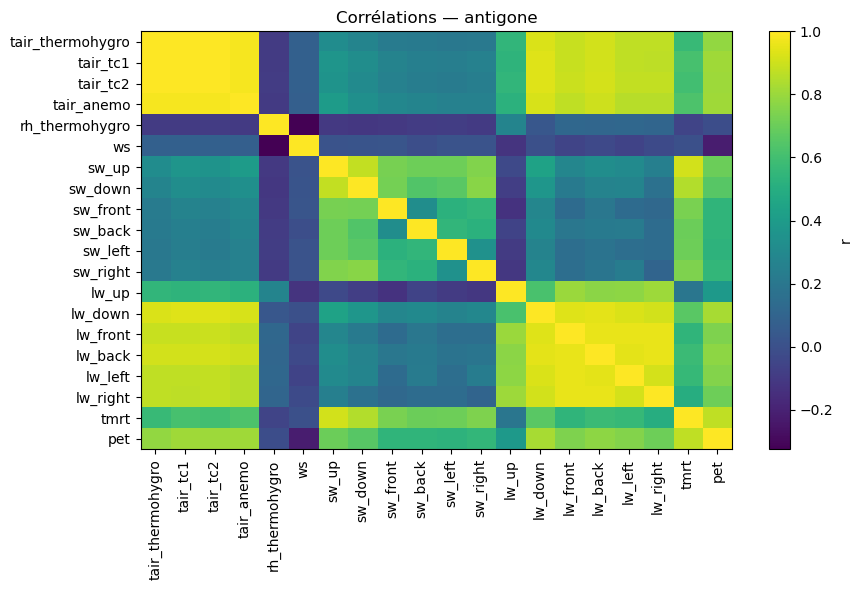

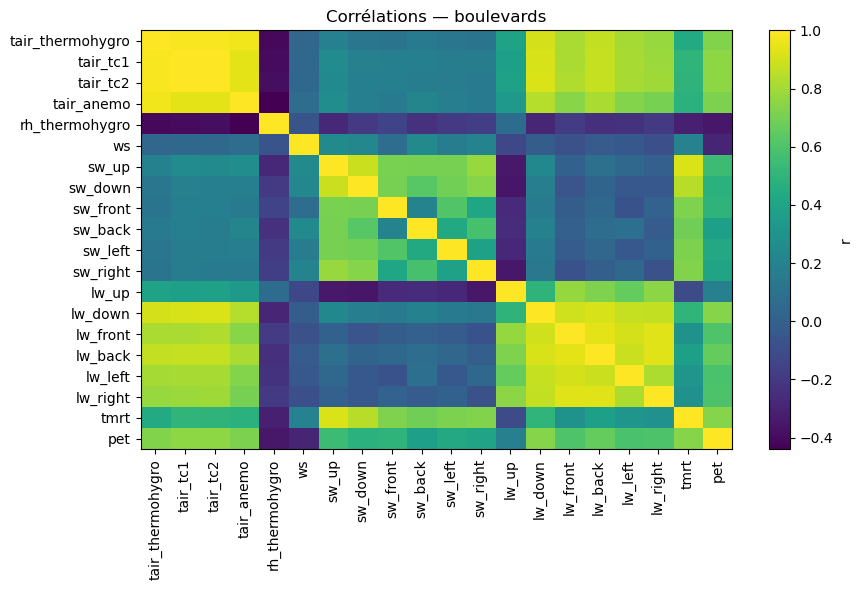

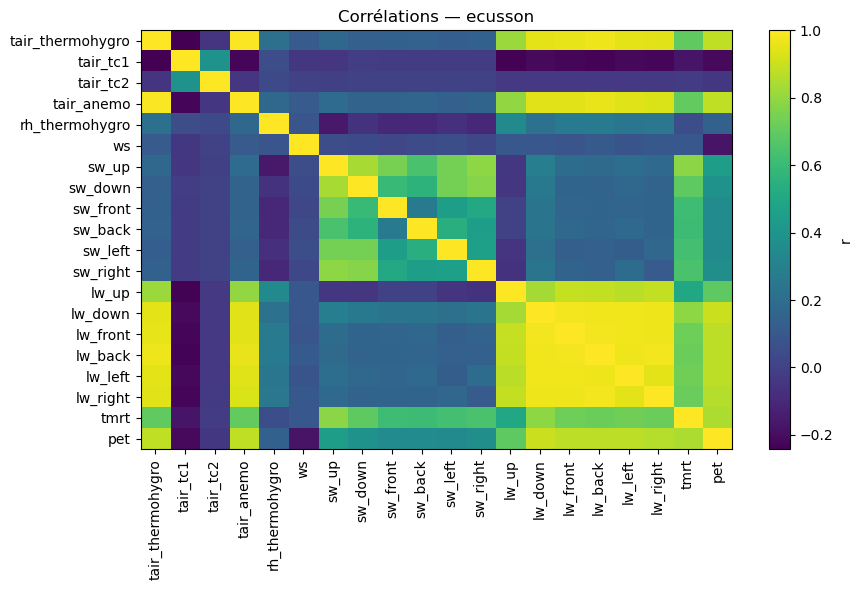

In [27]:
for t, g in raw.groupby("track_id"):
    # Sélection des variables numériques pertinentes
    sel = g[num_cols].select_dtypes(include=[np.number]).dropna(how="all", axis=1)
    
    if sel.shape[1] < 2: 
        print(f"Parcours {t} : pas assez de colonnes numériques pour corrélation.")
        continue

    # Calcul de la matrice de corrélation
    corr = sel.corr()

    # Visualisation
    plt.figure(figsize=(9, 6))
    plt.title(f"Corrélations — {t}")
    plt.imshow(corr, aspect="auto")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar(label="r")
    plt.tight_layout()

    # Sauvegarde et affichage
    plt.savefig(FIG_DIR / f"corr_{t}.png", dpi=150)
    plt.show()

##  Distribution des variables météo par parcours

Ce bloc affiche des **boxplots** (boîtes à moustaches) pour comparer la distribution de plusieurs variables météorologiques clés (`tair_thermohygro`, `tmrt`, `rh_thermohygro`, `ws`, `pet`) entre les différents parcours (`track_id`).

<Figure size 700x400 with 0 Axes>

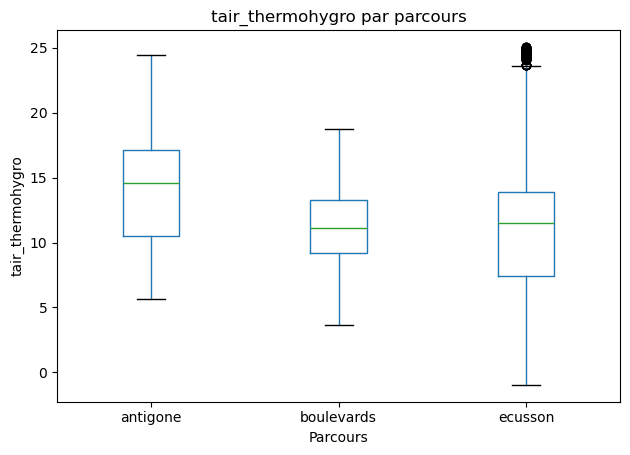

<Figure size 700x400 with 0 Axes>

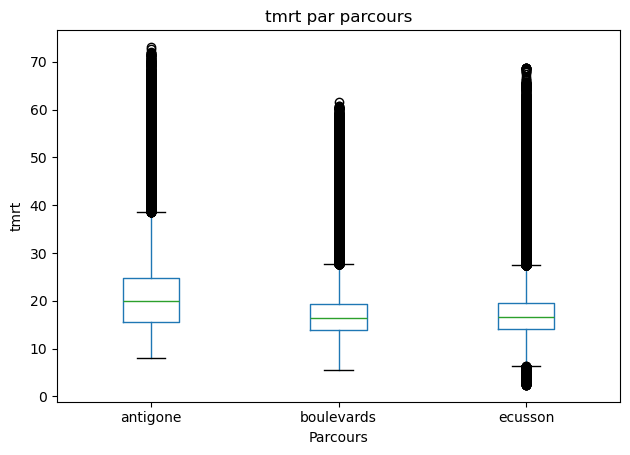

<Figure size 700x400 with 0 Axes>

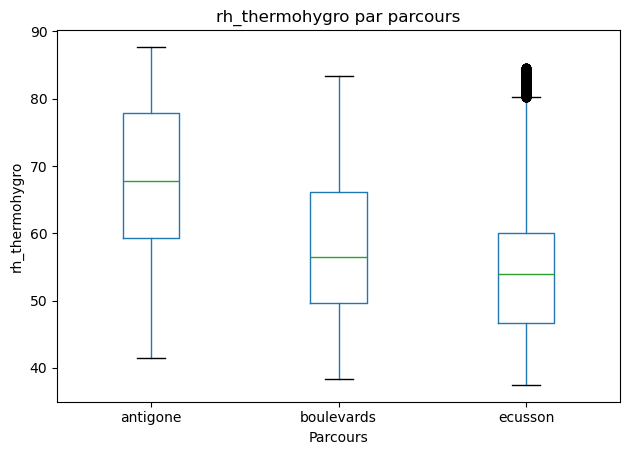

<Figure size 700x400 with 0 Axes>

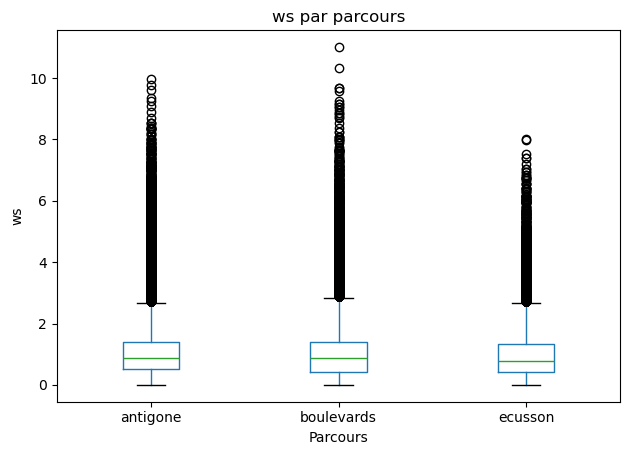

<Figure size 700x400 with 0 Axes>

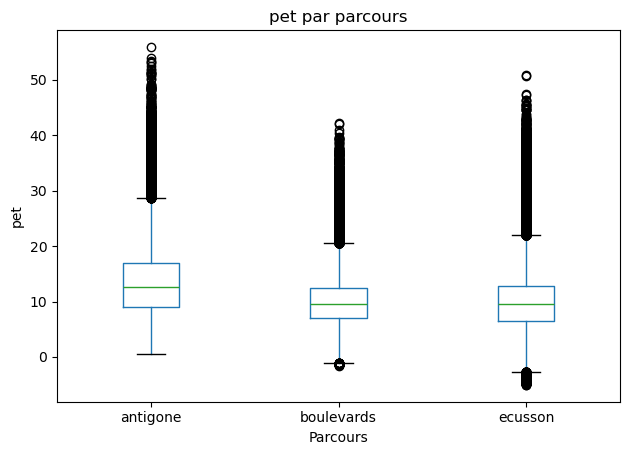

In [67]:
# Variables météo à visualiser
vars_plot = [v for v in ["tair_thermohygro", "tmrt", "rh_thermohygro", "ws", "pet"] if v in METEO]

for v in vars_plot:
    plt.figure(figsize=(7, 4))
    raw.boxplot(column=v, by="track_id", grid=False)
    plt.title(f"{v} par parcours")
    plt.suptitle("")  # supprime le titre automatique de pandas
    plt.xlabel("Parcours")
    plt.ylabel(v)
    plt.tight_layout()
    
    # Sauvegarde du graphique
    plt.savefig(FIG_DIR / f"box_{v}_parcours.png", dpi=150)
    plt.show()

## Distribution globale des variables météo

Ce bloc trace un **histogramme** pour chaque variable météo disponible, afin de visualiser la **répartition des valeurs mesurées** (et détecter d’éventuels biais ou valeurs extrêmes).

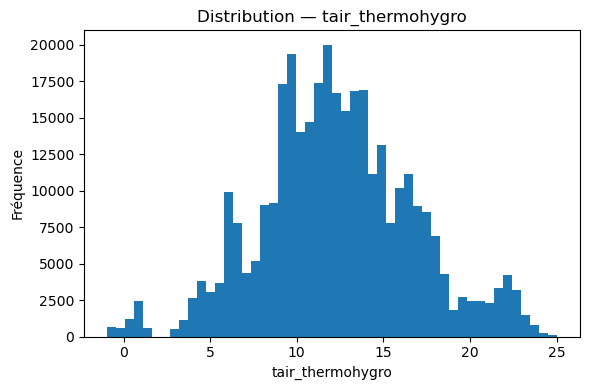

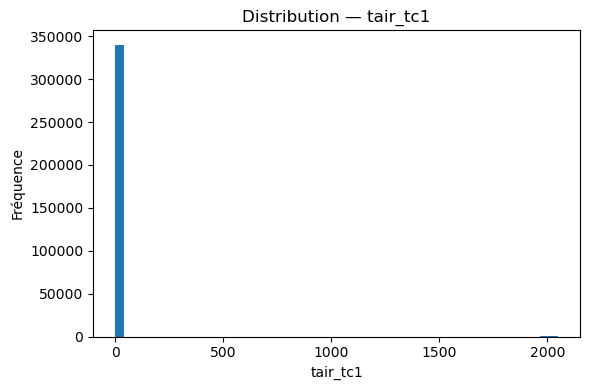

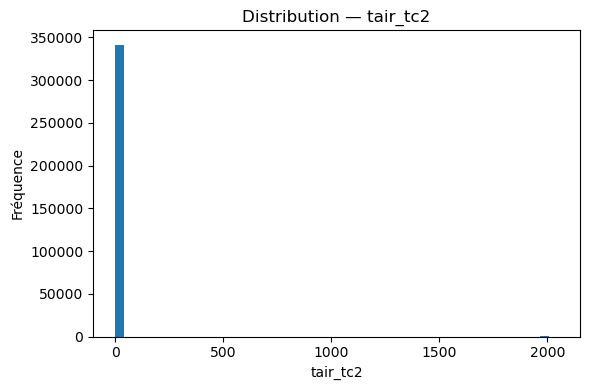

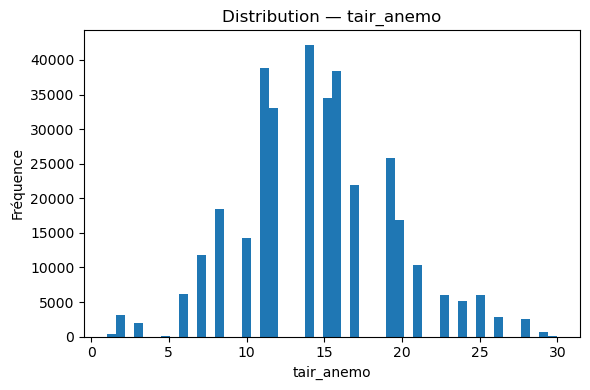

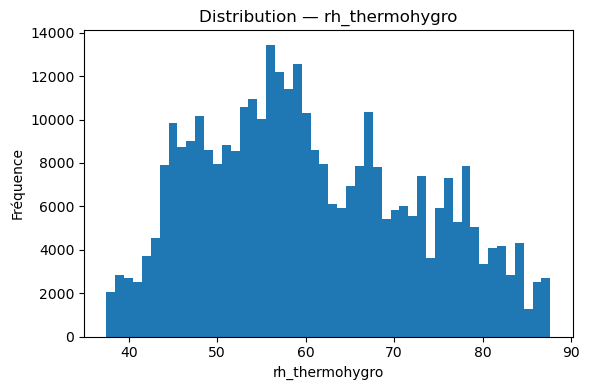

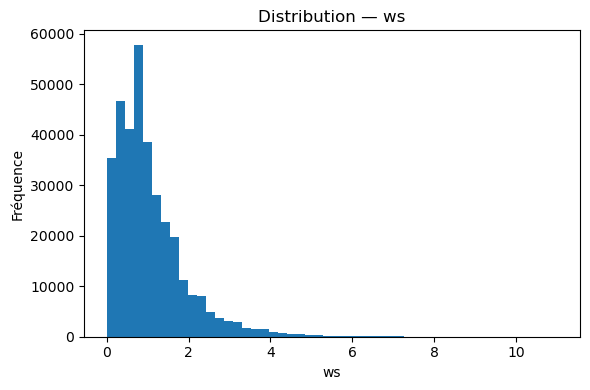

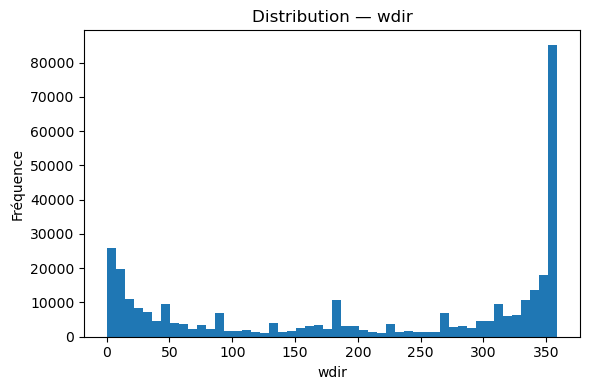

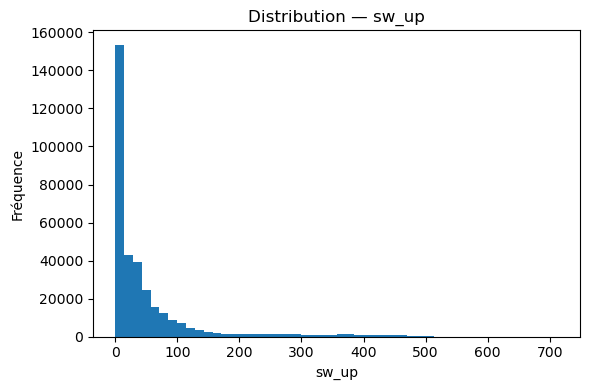

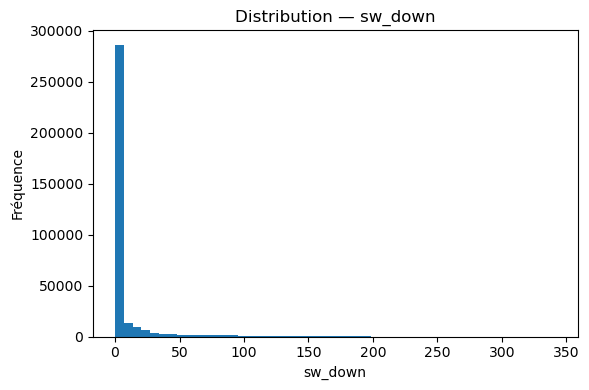

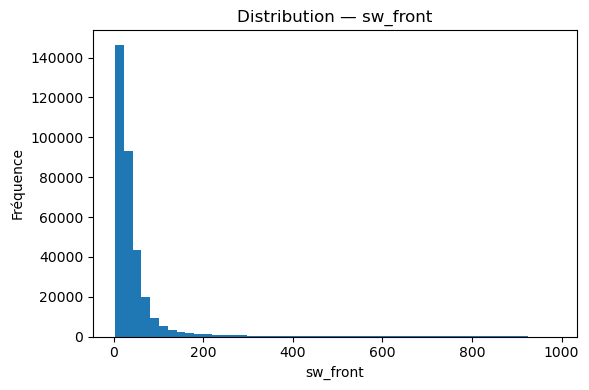

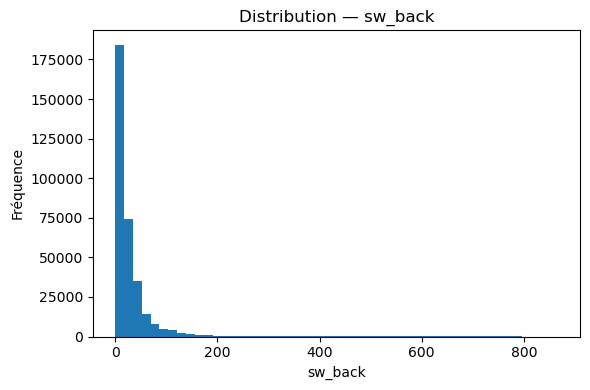

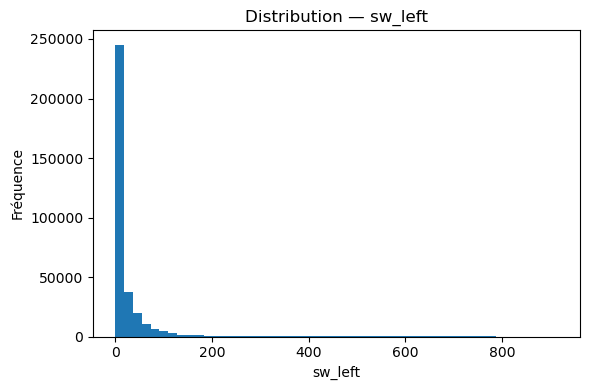

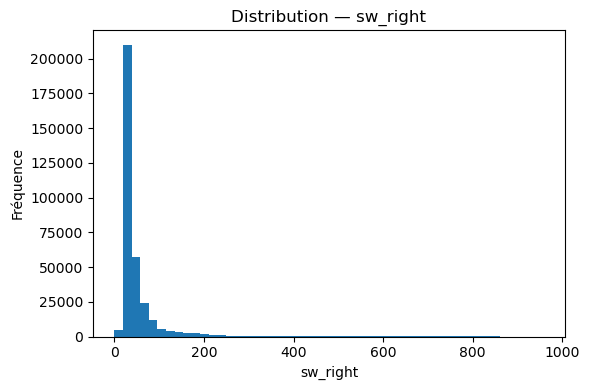

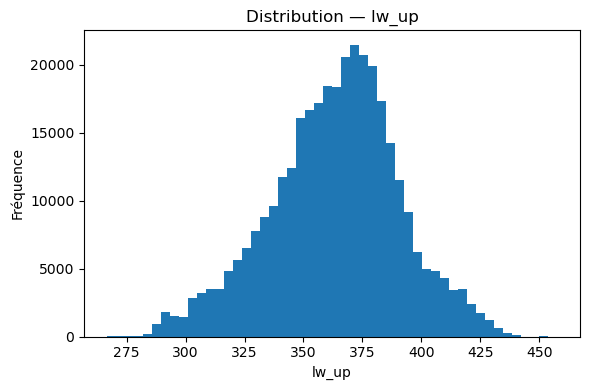

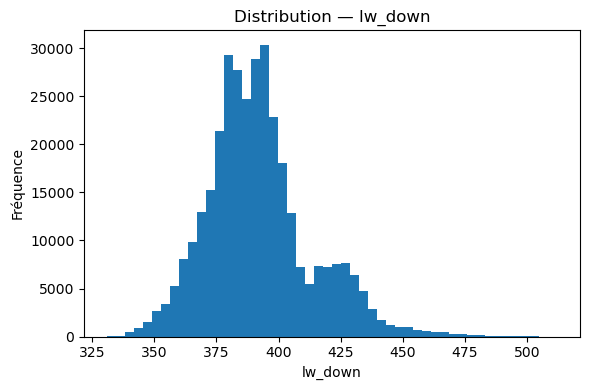

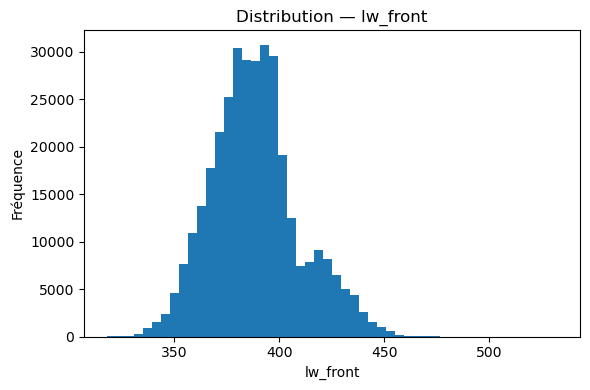

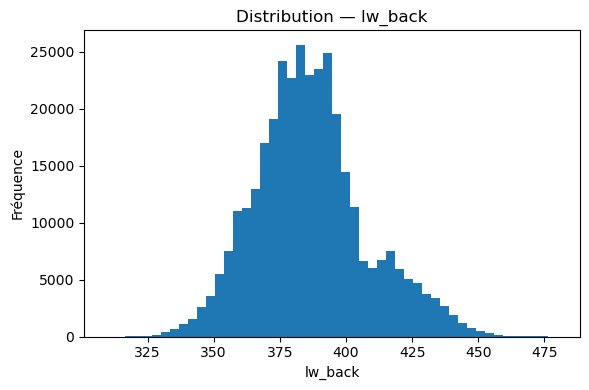

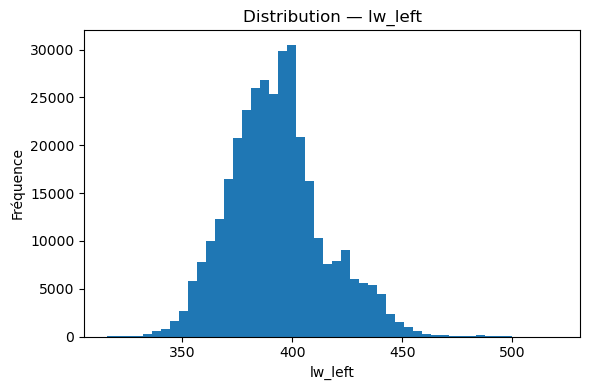

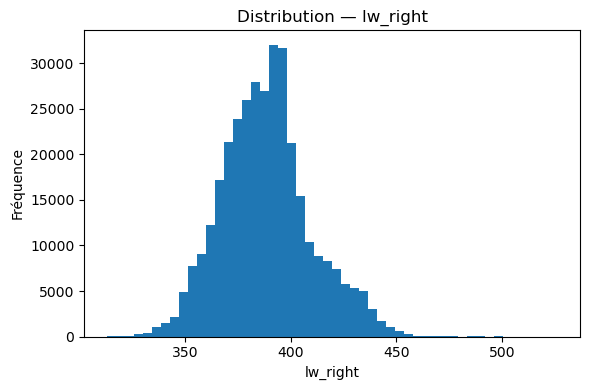

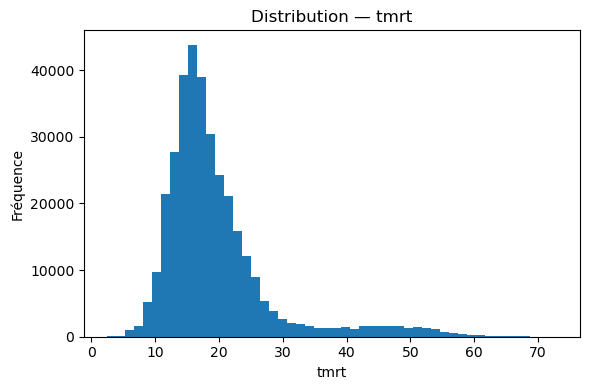

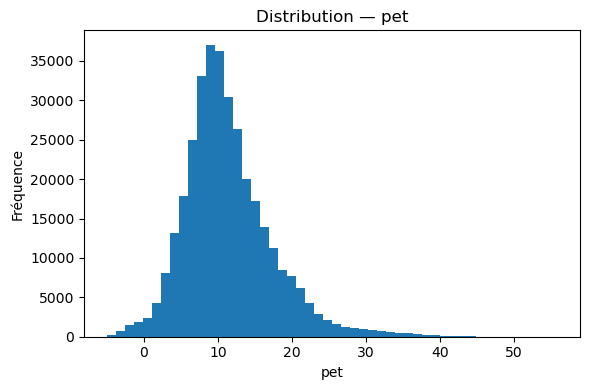

In [50]:
for v in METEO:
    s = raw[v].dropna()
    if len(s) == 0:
        continue

    plt.figure(figsize=(6, 4))
    plt.hist(s, bins=50)
    plt.title(f"Distribution — {v}")
    plt.xlabel(v)
    plt.ylabel("Fréquence")
    plt.tight_layout()

    # Sauvegarde et affichage
    plt.savefig(FIG_DIR / f"dist_global_{v}.png", dpi=150)
    plt.show()

## Moyennes et intervalles de confiance (IC95%) par parcours

Ce bloc calcule la **moyenne** et l’**intervalle de confiance à 95 %** pour chaque variable météo et chaque parcours (`track_id`).  
Les résultats sont visualisés sous forme de points avec barres d’erreur.

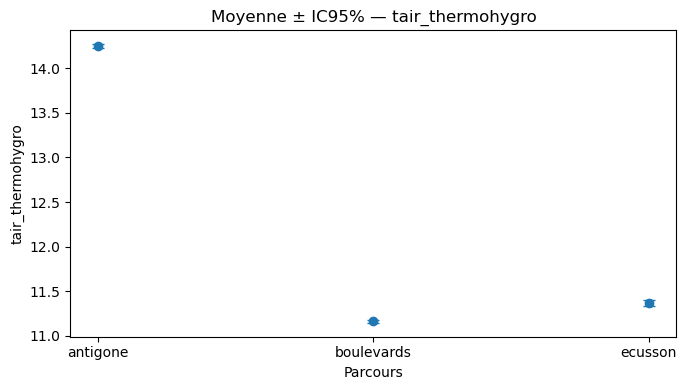

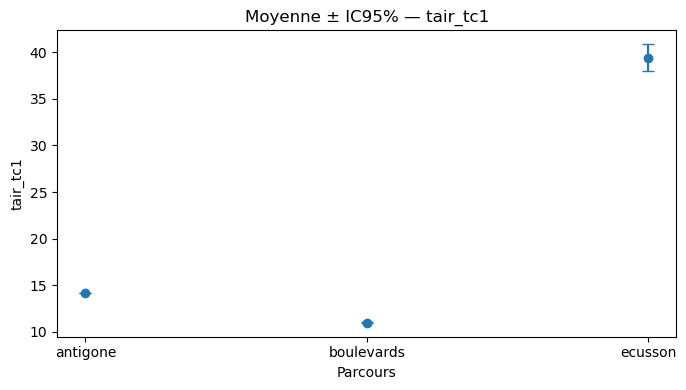

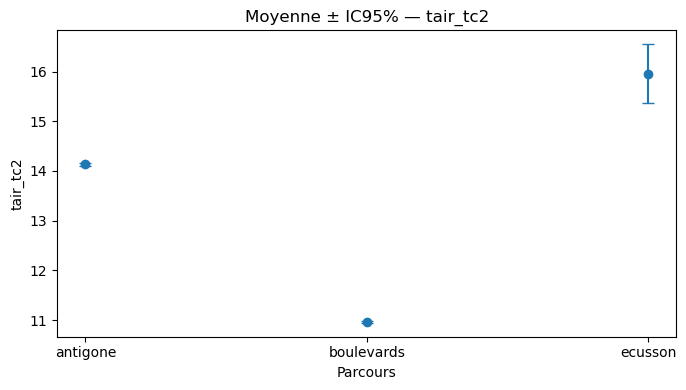

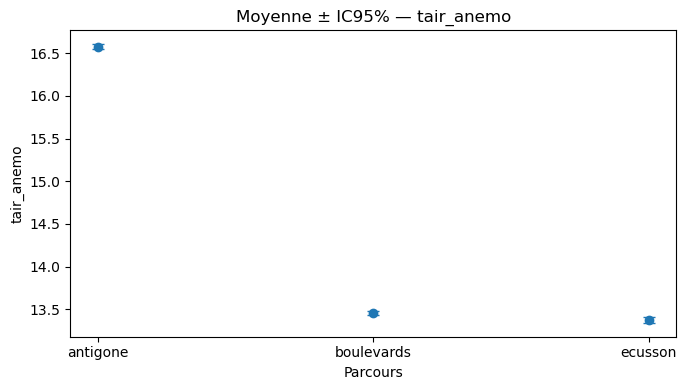

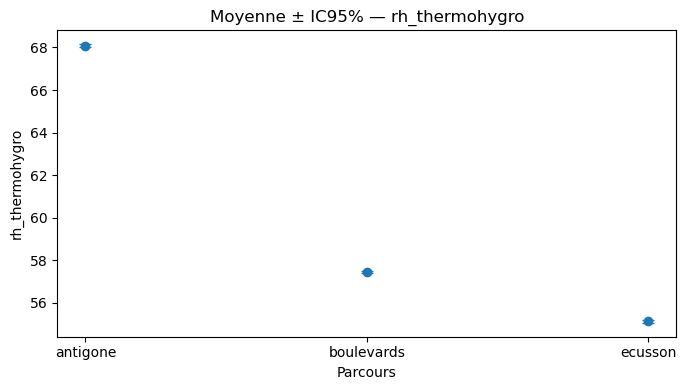

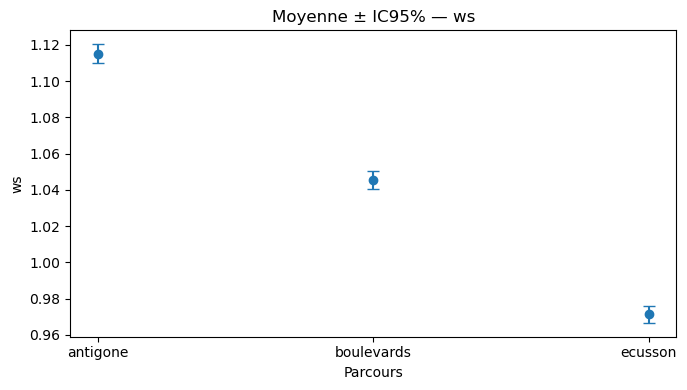

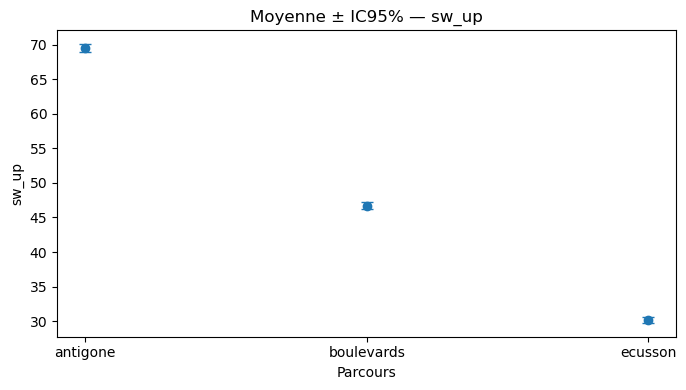

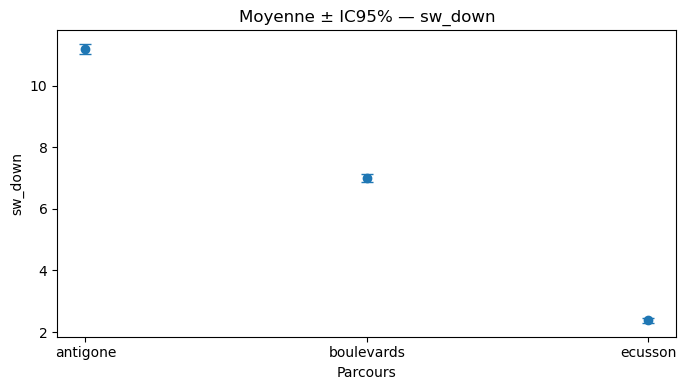

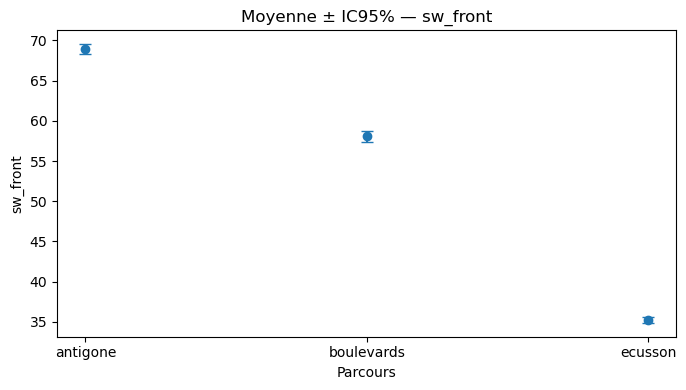

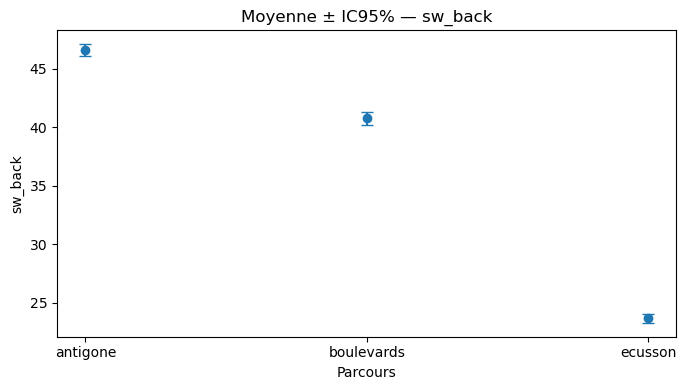

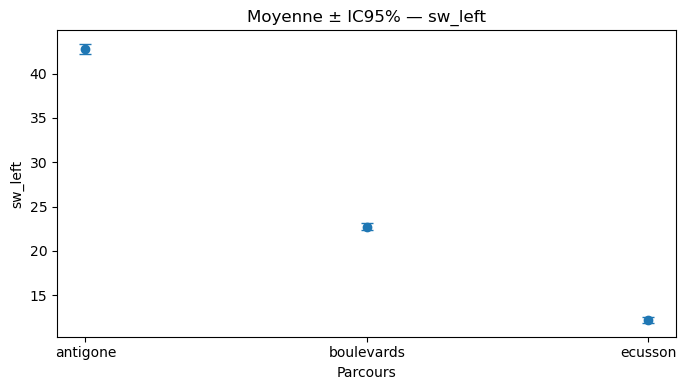

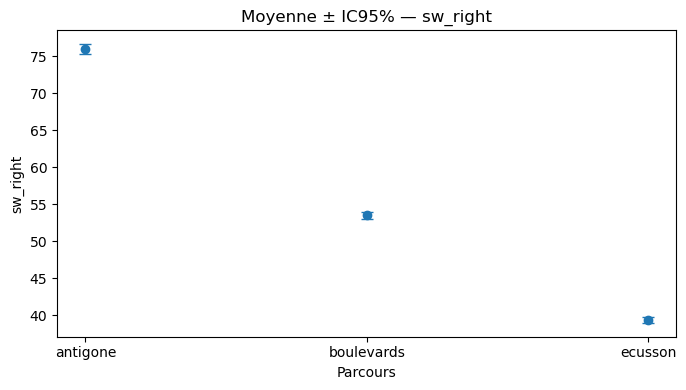

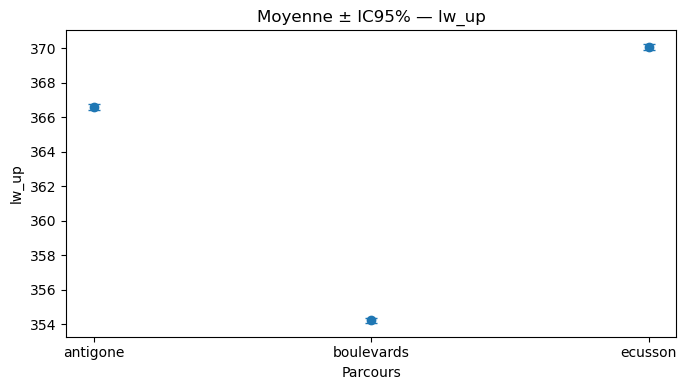

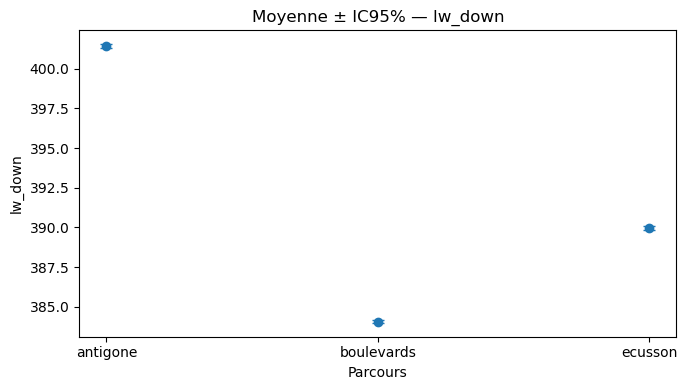

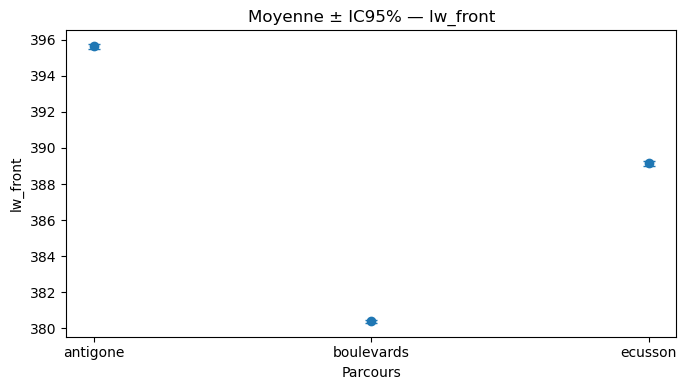

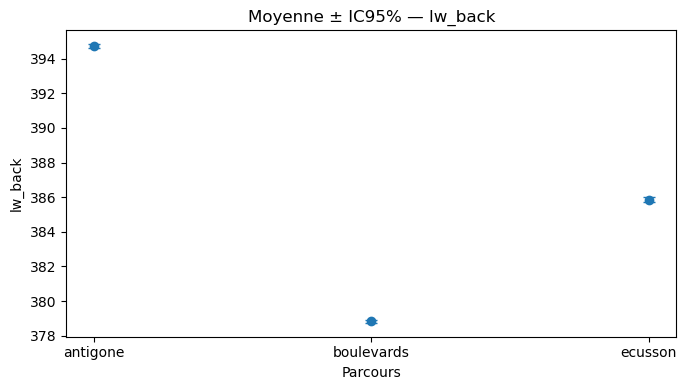

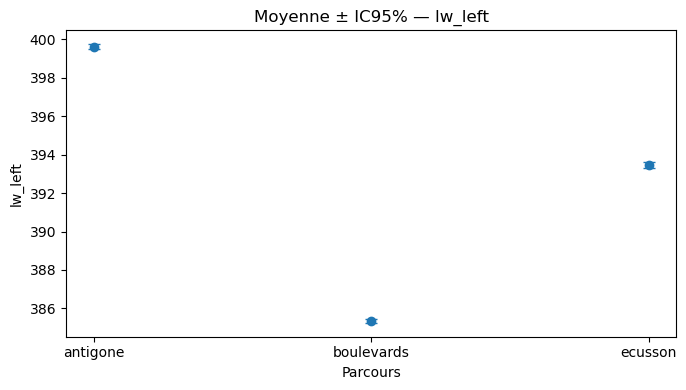

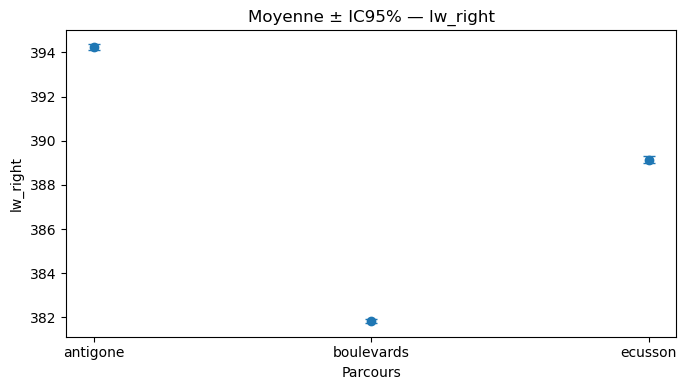

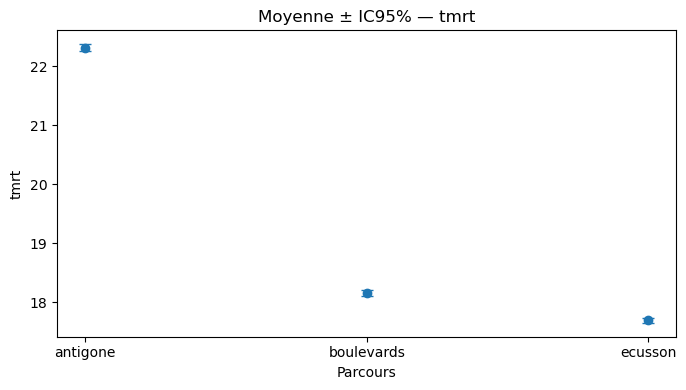

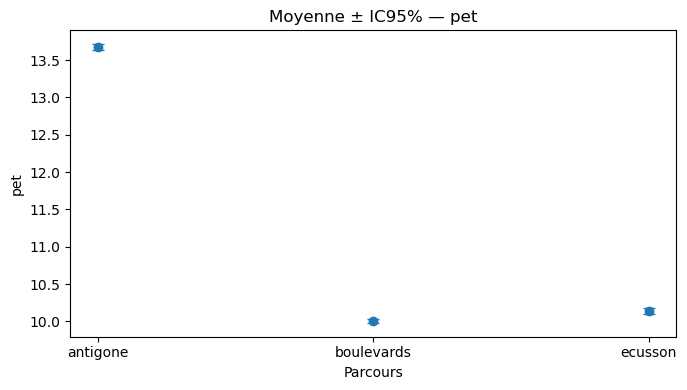

In [34]:
# Calcul des moyennes, écarts-types et effectifs par parcours
g = raw.groupby("track_id")[num_cols].agg(["mean", "std", "count"])

# Tracé des moyennes avec intervalles de confiance
for v in num_cols:
    m = g[(v, "mean")]
    se = g[(v, "std")] / np.sqrt(g[(v, "count")])
    ic = 1.96 * se  # Intervalle de confiance à 95 %

    plt.figure(figsize=(7, 4))
    plt.errorbar(m.index.astype(str), m.values, yerr=ic.values, fmt="o", capsize=4)
    plt.title(f"Moyenne ± IC95% — {v}")
    plt.xlabel("Parcours")
    plt.ylabel(v)
    plt.tight_layout()

    # Sauvegarde et affichage
    plt.savefig(FIG_DIR / f"mean_ic_{v}_parcours.png", dpi=150)
    plt.show()

##  Profil des variables météo selon le moment de la journée (M1–M4)

Ce bloc trace, pour chaque variable météo et pour les parcours principaux (**Antigone**, **Boulevards**, **Écusson**), l’évolution moyenne des valeurs selon les quatre créneaux horaires de mesure (`M1` à `M4`).

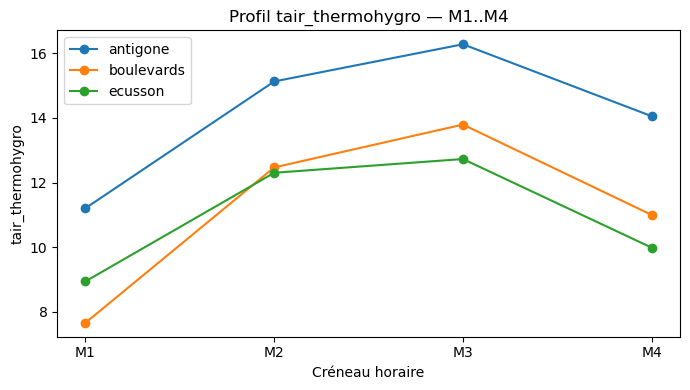

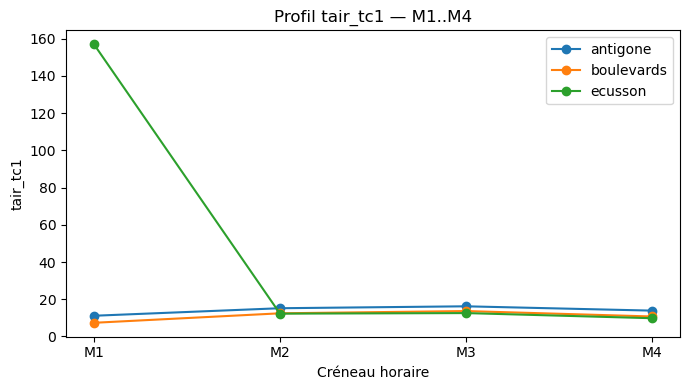

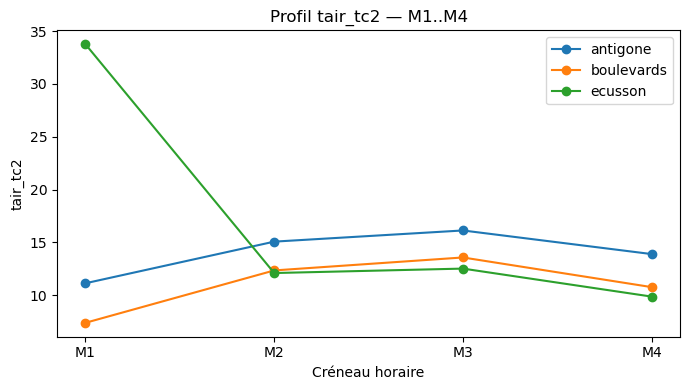

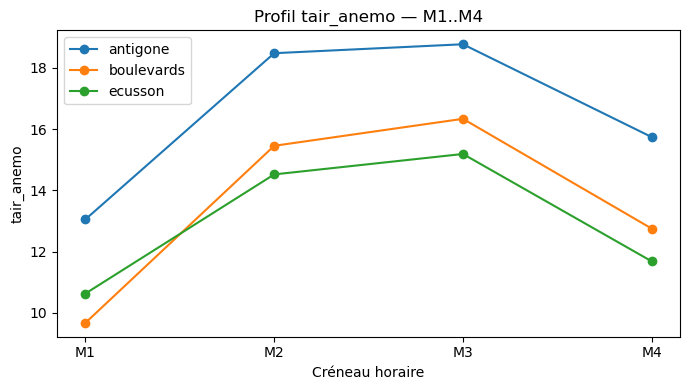

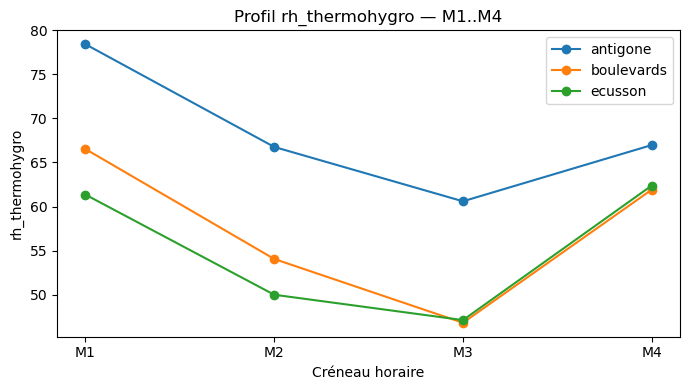

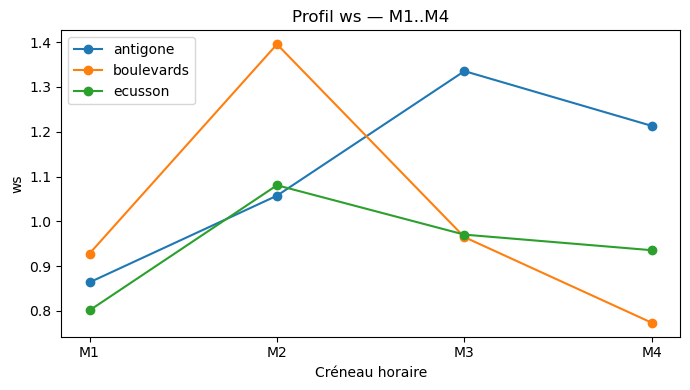

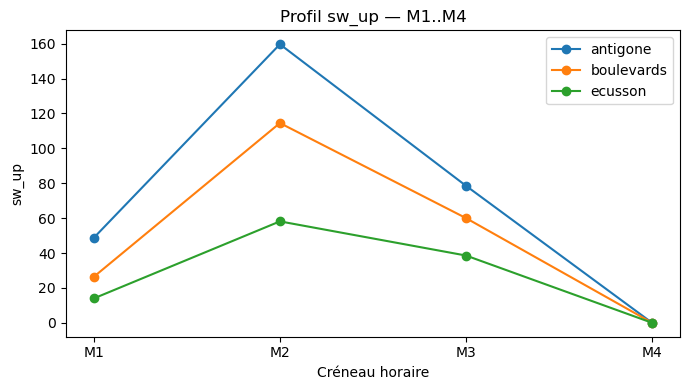

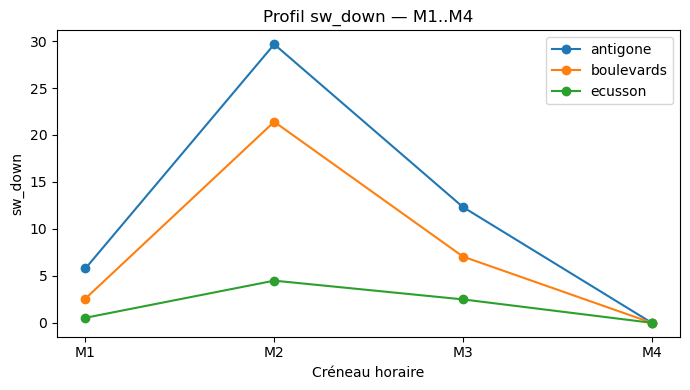

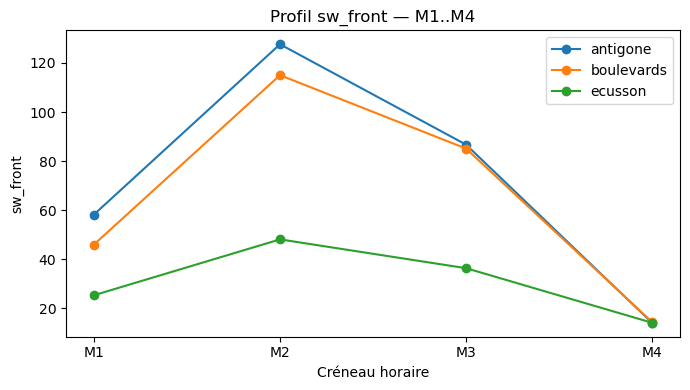

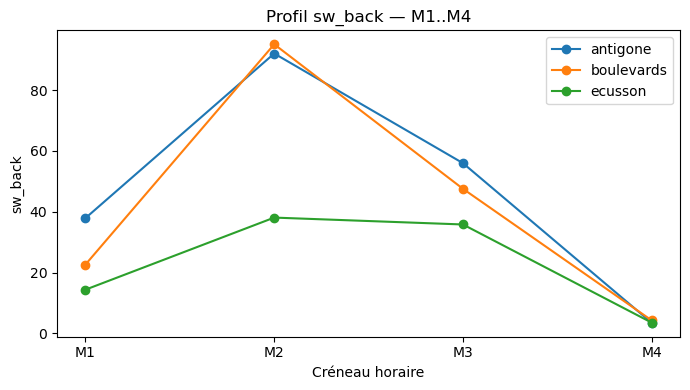

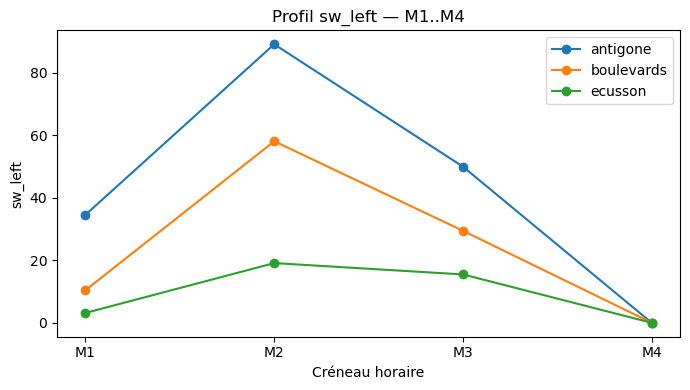

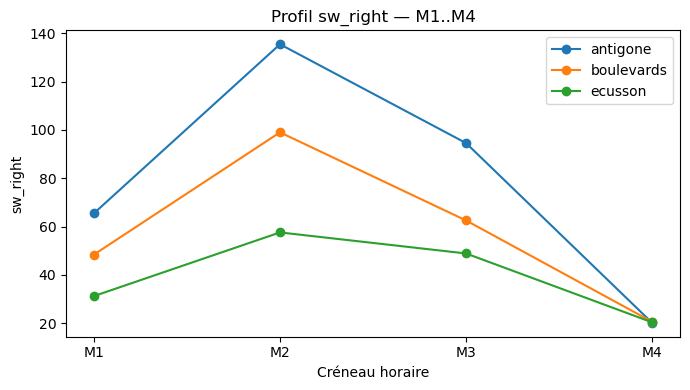

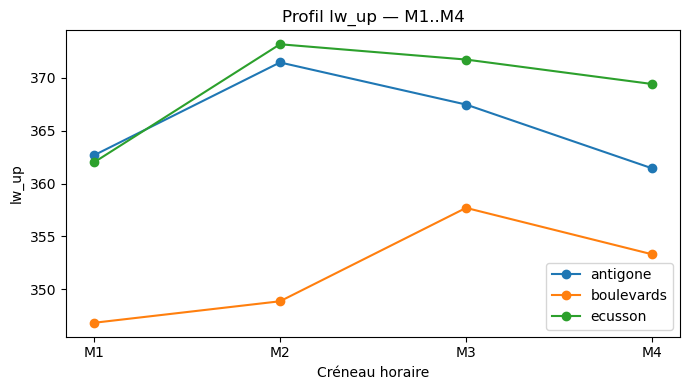

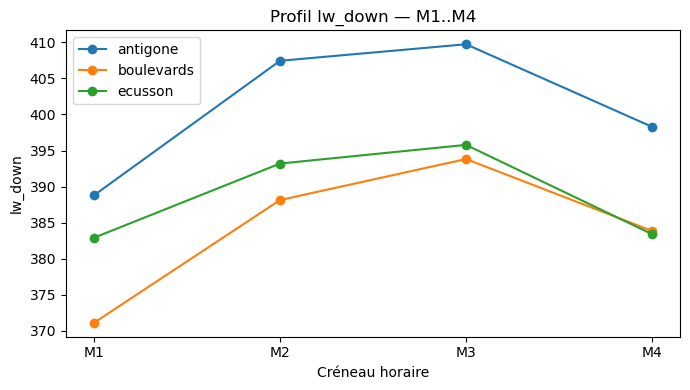

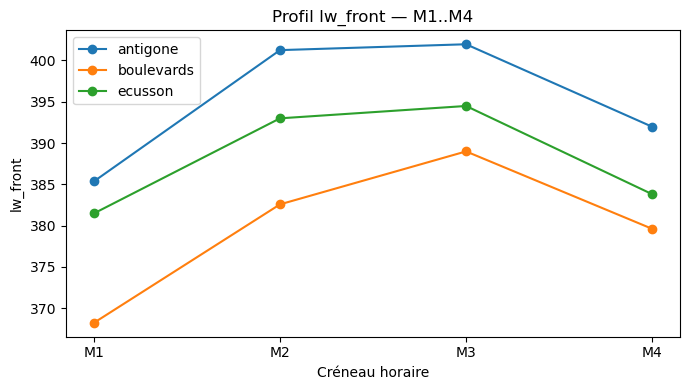

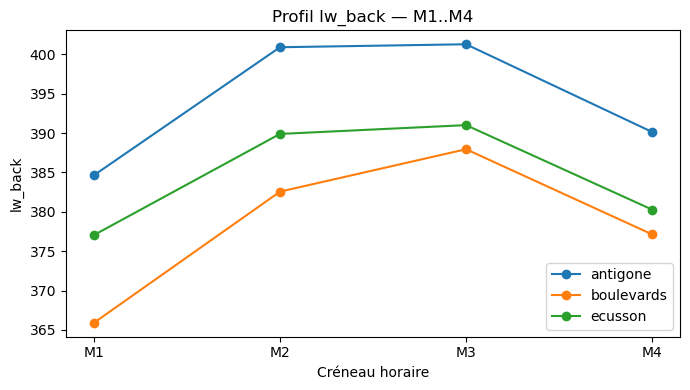

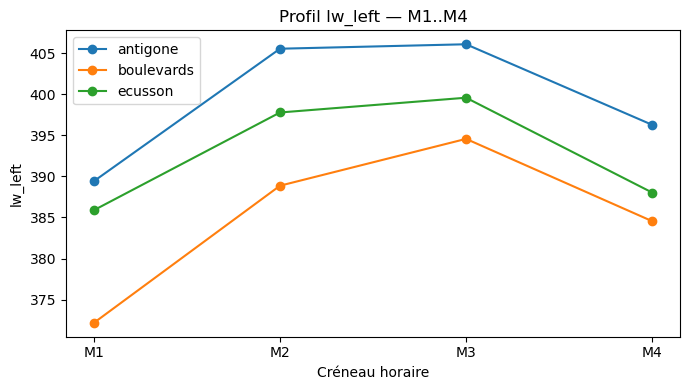

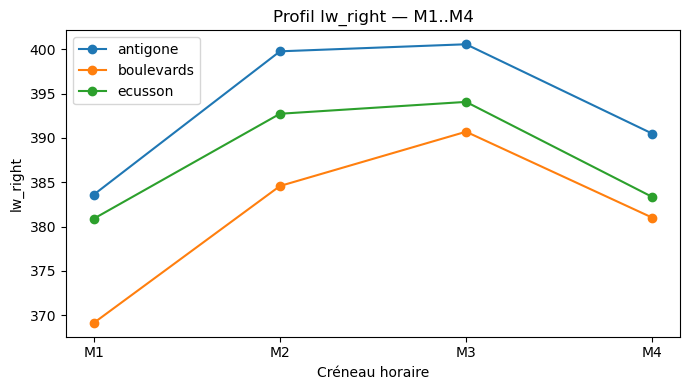

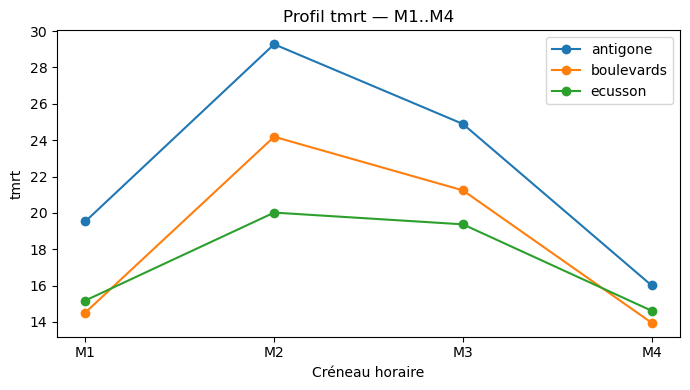

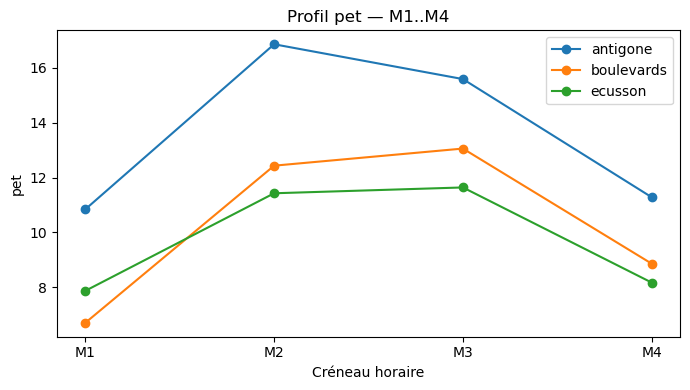

In [70]:
# Ordre des créneaux horaires
order = ["M1", "M2", "M3", "M4"]

# Moyenne des variables par parcours et créneau
agg = raw.groupby(["track_id", "M_slot"])[num_cols].mean().reset_index()

# Parcours à comparer
tracks_focus = ["antigone", "boulevards", "ecusson"]

# Tracé des profils journaliers
for v in num_cols:
    plt.figure(figsize=(7, 4))
    for t in tracks_focus:
        gg = agg[agg.track_id == t].set_index("M_slot").reindex(order)[v]
        if gg.isna().all():
            continue
        plt.plot(order, gg.values, marker="o", label=t)
    
    plt.title(f"Profil {v} — M1..M4")
    plt.xlabel("Créneau horaire")
    plt.ylabel(v)
    plt.legend()
    plt.tight_layout()

    # Sauvegarde et affichage
    plt.savefig(FIG_DIR / f"profile_{v}_Mslots.png", dpi=150)
    plt.show()

## Moyenne des variables météo par parcours

Ce bloc compare la **moyenne des variables météorologiques** principales entre les trois parcours étudiés : **Antigone**, **Boulevards** et **Écusson**.Les résultats sont présentés sous forme d’histogrammes.

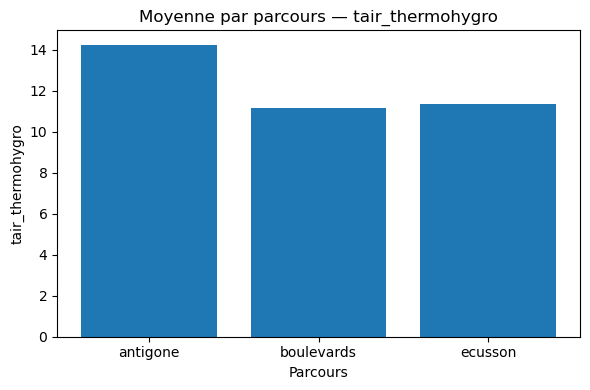

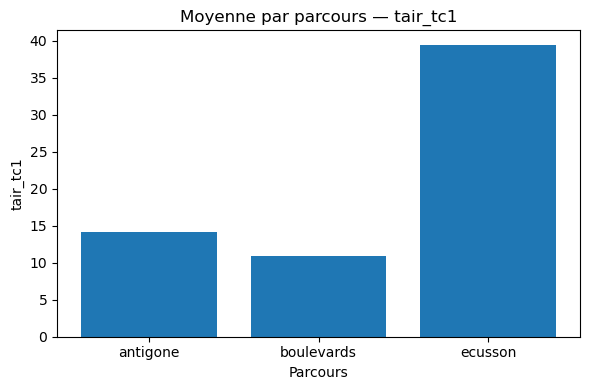

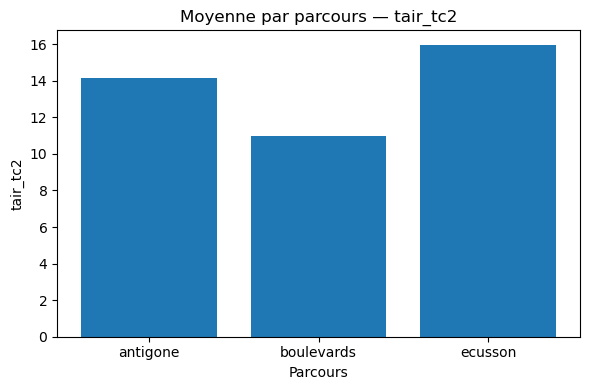

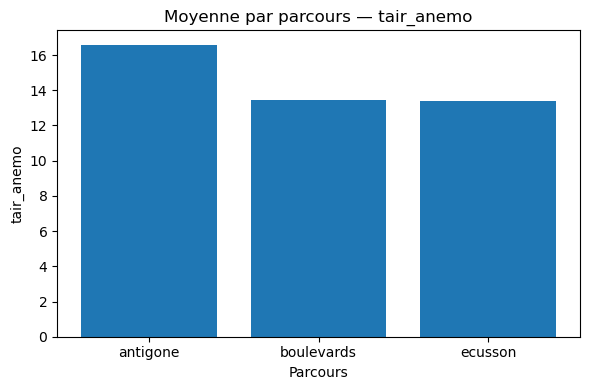

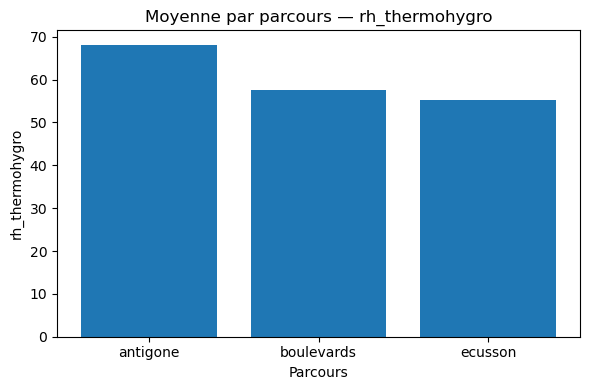

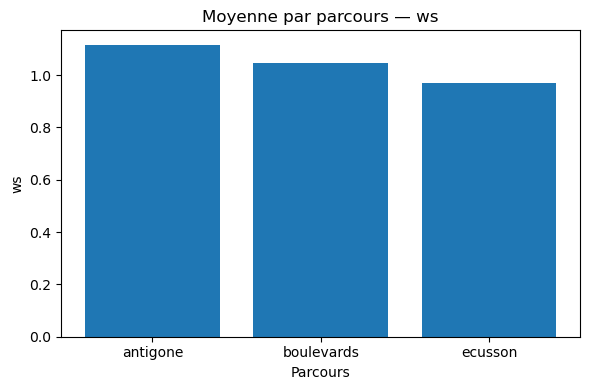

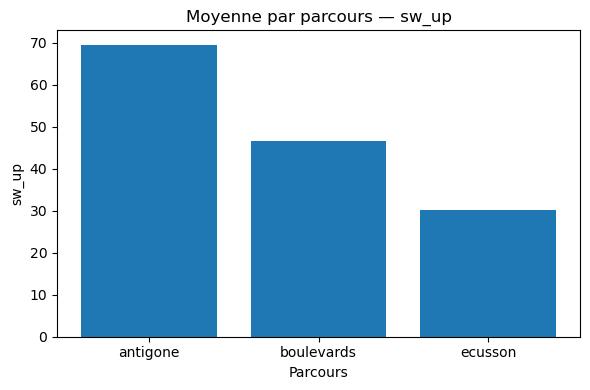

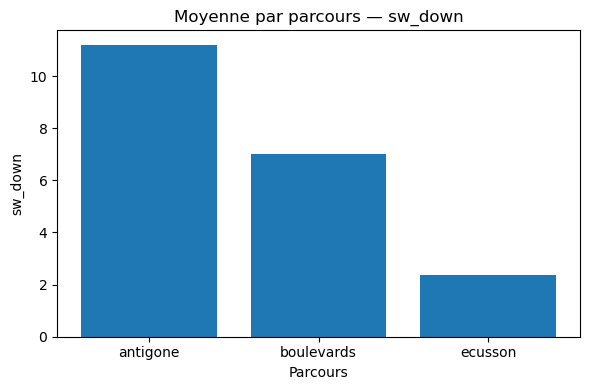

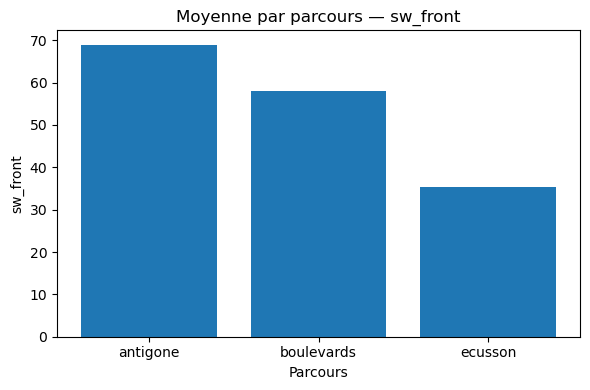

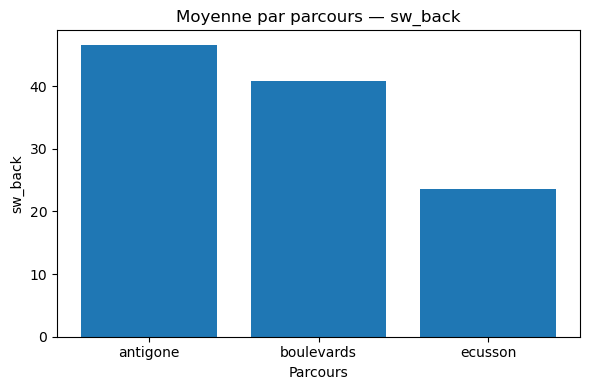

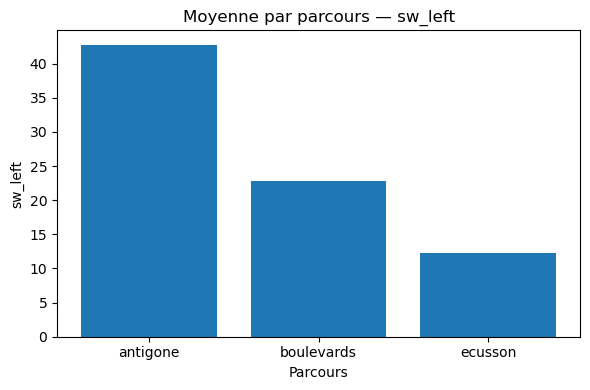

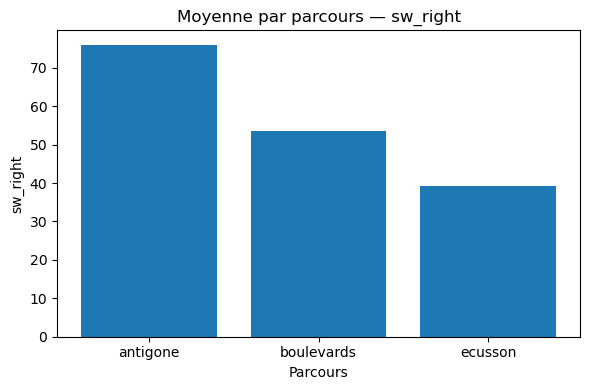

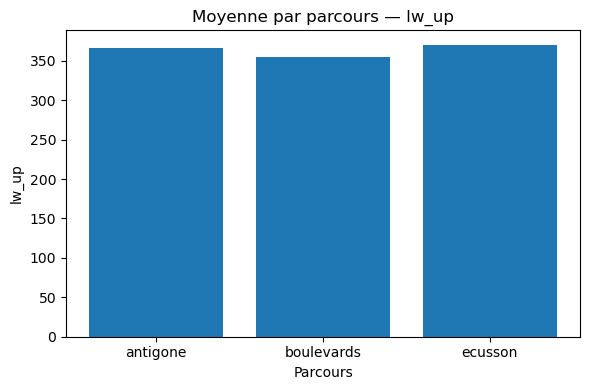

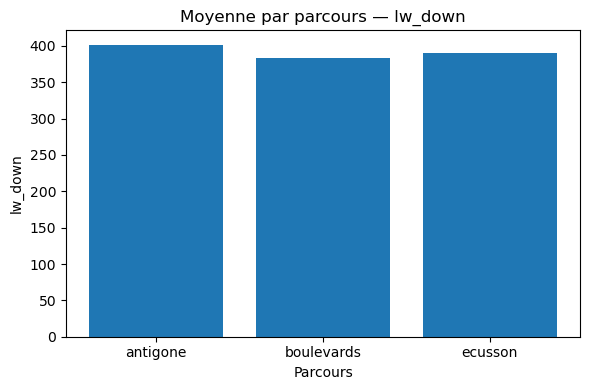

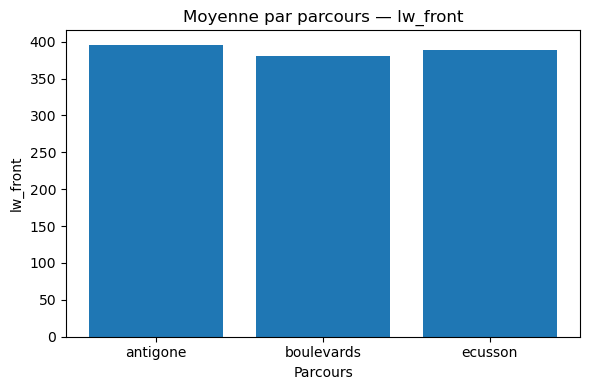

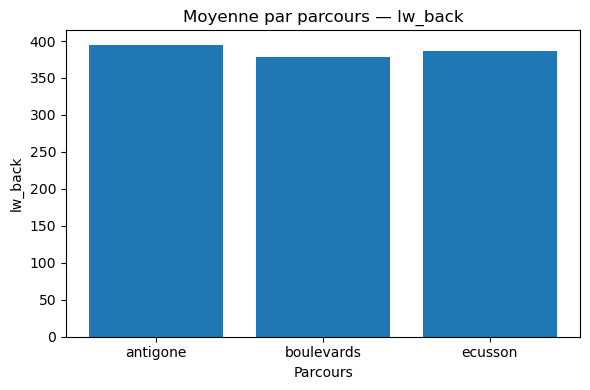

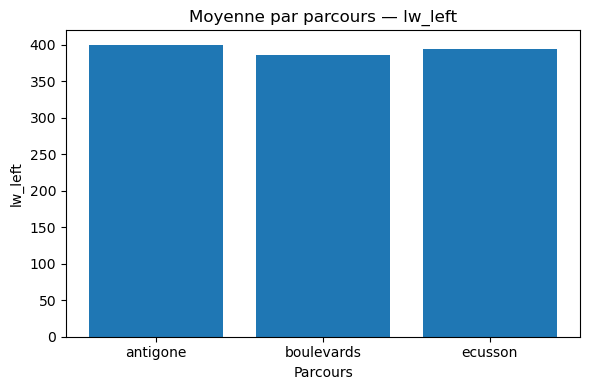

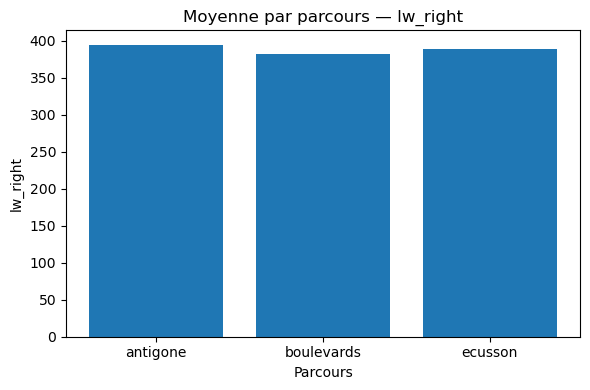

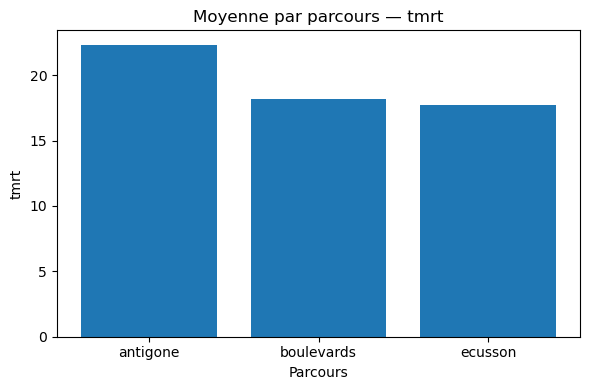

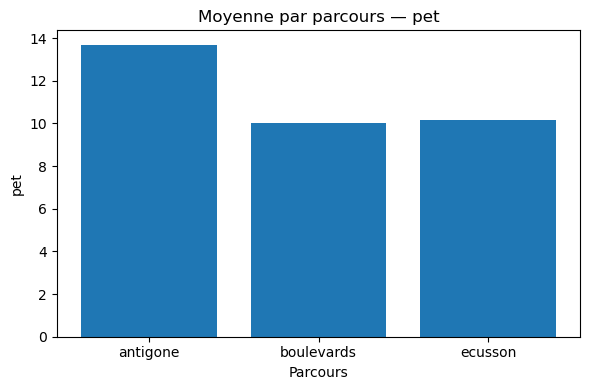

In [56]:
# Sélection des parcours d'intérêt et calcul des moyennes
comp = (raw[raw["track_id"].isin(["antigone", "boulevards", "ecusson"])]
          .groupby("track_id")[num_cols]
          .mean()
          .T)

# Tracé des moyennes par variable
for v in comp.index:
    plt.figure(figsize=(6, 4))
    plt.bar(comp.columns.astype(str), comp.loc[v].values)
    plt.title(f"Moyenne par parcours — {v}")
    plt.xlabel("Parcours")
    plt.ylabel(v)
    plt.tight_layout()

    # Sauvegarde et affichage
    plt.savefig(FIG_DIR / f"bar_mean_{v}_parcours.png", dpi=150)
    plt.show()

##  Visualisation spatiale de la température de l’air

Ce bloc trace la **position GPS** des points de mesure (`lon`, `lat`) et colore les points selon la **température de l’air (`tair_thermohygro`)** pour chaque parcours. Cela permet de visualiser les variations de température le long du trajet.

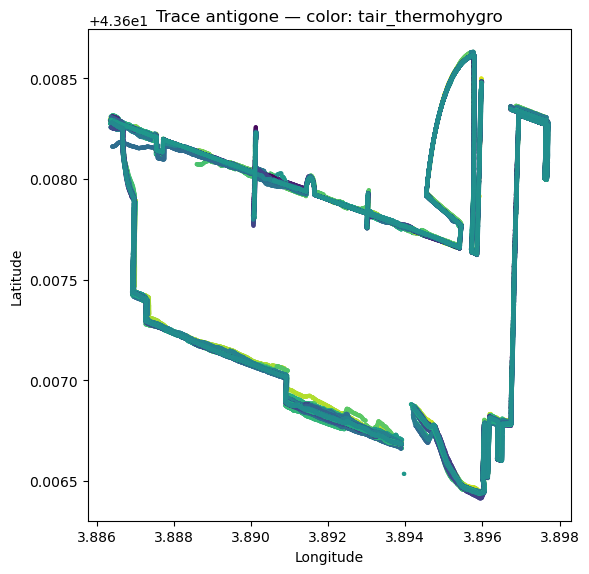

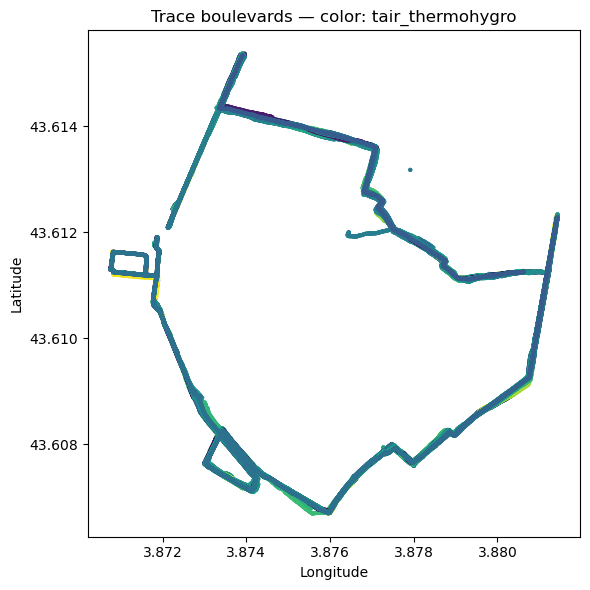

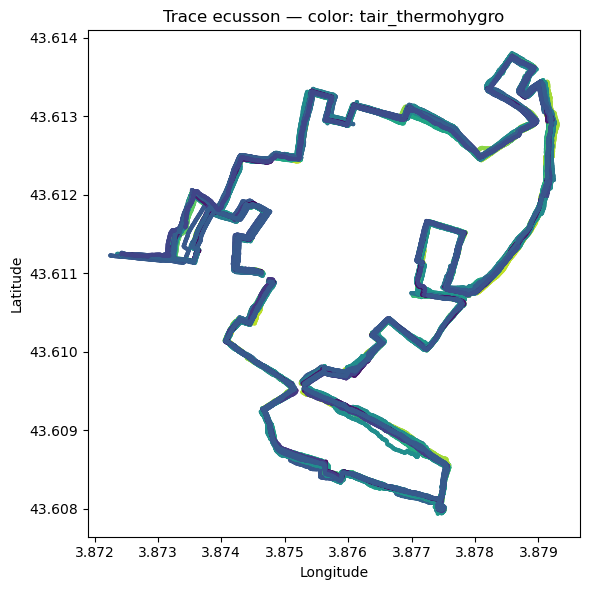

In [59]:
# Vérifie la présence des colonnes nécessaires avant de tracer
if {"lat", "lon"}.issubset(raw.columns) and "tair_thermohygro" in raw.columns:
    # Boucle sur chaque parcours
    for t, g in raw.groupby("track_id"):
        s = g.dropna(subset=["lat", "lon", "tair_thermohygro"])
        if s.empty:
            continue
        plt.figure(figsize=(6, 6))
        plt.scatter(s["lon"], s["lat"], c=s["tair_thermohygro"], s=4)
        plt.title(f"Trace {t} — color: tair_thermohygro")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.tight_layout()
        plt.savefig(FIG_DIR / f"map_tair_{t}.png", dpi=150)
        plt.show()